# IA et Médecine Personnalisée
## Des Statistiques Conventionnelles à la Médecine Personnalisée

**UE IA en Santé - Module 5**

*Université de Toulouse - Faculté de Santé*

---

### Objectifs pédagogiques

À l'issue de ce module, vous serez capables de :

1. Comprendre la progression méthodologique des tests statistiques aux algorithmes d'apprentissage automatique
2. Identifier les avantages et limites de chaque approche (interprétabilité, performance, complexité)
3. Appliquer différentes méthodes sur des données réelles de santé (Framingham Heart Study)
4. Quantifier l'impact personnalisé d'interventions cliniques pour un patient donné
5. Choisir la méthode appropriée selon le contexte clinique

### Organisation

**Partie 1 : Progression méthodologique** (1h15)
- Introduction et présentation des données
- Étape 1 : Tests univariés (Chi², Student)
- Étape 2 : Régression logistique classique (Odds Ratios)
- Étape 3 : Régression logistique régularisée (Lasso/Ridge)
- Étape 4 : Random Forest
- Étape 5 : Gradient Boosting (XGBoost)
- Étape 6 : Neural Networks
- Synthèse comparative

**Partie 2 : Concepts avancés** (45 min)
*À venir : Enveloppe convexe, jumeaux numériques, data overload*

---

### Principe du cours

Ce cours est **interactif**. Vous utiliserez des widgets pour :
- Explorer l'impact des différentes méthodes sur les mêmes données
- Modifier les paramètres des modèles et observer les conséquences
- Tester des scénarios cliniques sur un patient témoin
- Comparer les prédictions selon les approches

Aucune connaissance préalable en programmation n'est requise.

In [1]:
# Configuration de l'environnement

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, FloatSlider, IntSlider, Dropdown, Checkbox, HTML
import ipywidgets as widgets
from IPython.display import display, clear_output

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve, 
                             confusion_matrix, classification_report, log_loss)
from sklearn.preprocessing import StandardScaler

# Statistiques
from scipy.stats import chi2_contingency, ttest_ind
import scipy.stats as stats

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Kaggle (avec fallback)
try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    KAGGLE_AVAILABLE = True
except ImportError:
    KAGGLE_AVAILABLE = False

# Graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Seed pour reproductibilité
np.random.seed(42)

print("Environnement configuré avec succès")
print("Prêt pour l'analyse interactive")

Environnement configuré avec succès
Prêt pour l'analyse interactive


---

# Introduction : Le Défi de la Médecine Personnalisée

## Contexte clinique

La médecine contemporaine fait face à un paradoxe fondamental :

Les **essais cliniques randomisés** nous indiquent qu'un traitement A est supérieur à un traitement B **en moyenne dans une population**. Cependant, devant un patient particulier, le clinicien doit décider : *"Pour CE patient précis, avec SON profil unique, quel est le meilleur choix ?"*

### Le rôle de l'Evidence-Based Medicine (EBM)

L'EBM s'appuie sur trois piliers :
1. Les **meilleures preuves scientifiques** disponibles (essais cliniques, méta-analyses)
2. L'**expertise clinique** du praticien
3. Les **préférences du patient**

L'EBM fournit le cadre général issu des données populationnelles, que le clinicien adapte au cas individuel grâce à son expertise.

### Le rôle de l'intelligence artificielle

L'IA ne remplace pas l'EBM, elle la **complète** en :
- Calculant des scores de risque **individualisés** plutôt que populationnels
- Intégrant simultanément de **multiples variables** cliniques
- Détectant des **interactions complexes** entre facteurs de risque
- Quantifiant précisément le **bénéfice attendu** d'une intervention

### Question centrale

**Comment passer d'une conclusion populationnelle ("Le tabac multiplie le risque cardiovasculaire par 2 en moyenne") à une prédiction individuelle ("Pour ce patient spécifique, arrêter de fumer réduirait son risque de 8.3 points de pourcentage") ?**

Nous explorerons cette question à travers une **progression méthodologique**, des tests statistiques classiques aux algorithmes d'apprentissage profond, en évaluant à chaque étape les gains en performance et les compromis en interprétabilité.

---

## Notre Jeu de Données : Framingham Heart Study

### Contexte historique

La **Framingham Heart Study** est l'une des études de cohorte les plus influentes de l'histoire de la cardiologie :

**Caractéristiques** :
- **Début** : 1948, Framingham (Massachusetts, USA)
- **Population** : Plus de 4,000 participants suivis sur plusieurs décennies
- **Objectif** : Identifier les facteurs de risque cardiovasculaire
- **Contributions majeures** : 
  - Introduction du concept de "facteur de risque"
  - Démonstration du rôle du cholestérol, de l'hypertension, du tabagisme
  - Développement des premiers scores de risque cardiovasculaire

### Variables disponibles (16 au total)

**Démographiques** :
- `age` : Âge en années
- `male` : Sexe (1=Homme, 0=Femme)
- `education` : Niveau d'études (1 à 4)

**Comportementales** :
- `currentSmoker` : Fumeur actuel (1=Oui, 0=Non)
- `cigsPerDay` : Nombre de cigarettes par jour

**Cliniques** :
- `sysBP` : Pression artérielle systolique (mmHg)
- `diaBP` : Pression artérielle diastolique (mmHg)
- `heartRate` : Fréquence cardiaque (bpm)

**Biologiques** :
- `totChol` : Cholestérol total (mg/dL)
- `glucose` : Glycémie à jeun (mg/dL)

**Anthropométriques** :
- `BMI` : Indice de masse corporelle (kg/m²)

**Antécédents** :
- `prevalentStroke` : Antécédent d'AVC
- `prevalentHyp` : Hypertension artérielle
- `diabetes` : Diabète
- `BPMeds` : Traitement antihypertenseur

**Variable d'intérêt** :
- `TenYearCHD` : Survenue d'un événement coronarien dans les 10 ans (0=Non, 1=Oui)

### Objectif de notre analyse

Prédire le risque d'événement cardiovasculaire à 10 ans (`TenYearCHD`) à partir des caractéristiques du patient, en comparant différentes approches méthodologiques.

In [2]:
# Chargement du dataset Framingham

def load_framingham_data():
    """Charge le dataset Framingham depuis Kaggle ou crée des données simulées"""
    
    if KAGGLE_AVAILABLE:
        try:
            print("Tentative de téléchargement depuis Kaggle...")
            file_path = "framingham.csv"
            df = kagglehub.load_dataset(
                KaggleDatasetAdapter.PANDAS,
                "aasheesh200/framingham-heart-study-dataset",
                file_path
            )
            print("Dataset Framingham chargé depuis Kaggle")
            return df
        except Exception as e:
            print(f"Erreur Kaggle : {e}")
            print("Basculement vers données simulées...")
            return create_simulated_framingham()
    else:
        # Essayer de charger depuis fichier local
        try:
            df = pd.read_csv("framingham.csv")
            print("Dataset chargé depuis fichier local")
            return df
        except:
            print("Création de données simulées réalistes...")
            return create_simulated_framingham()

def create_simulated_framingham():
    """Crée des données simulées mimant les caractéristiques de Framingham"""
    n = 4240
    
    # Génération de données réalistes avec corrélations
    age = np.random.normal(50, 12, n).clip(30, 70).astype(int)
    male = np.random.binomial(1, 0.45, n)
    education = np.random.choice([1.0, 2.0, 3.0, 4.0], n, p=[0.2, 0.3, 0.3, 0.2])
    
    # Tabagisme
    currentSmoker = np.random.binomial(1, 0.35, n)
    cigsPerDay = currentSmoker * np.random.poisson(15, n).astype(float)
    
    # Variables physiologiques corrélées
    sysBP_base = 110 + (age - 50) * 0.5 + male * 5
    sysBP = sysBP_base + np.random.normal(0, 15, n)
    sysBP = sysBP.clip(90, 200)
    
    diaBP = sysBP * 0.65 + np.random.normal(0, 5, n)
    diaBP = diaBP.clip(60, 110)
    
    totChol = 200 + (age - 50) * 0.8 + np.random.normal(0, 40, n)
    totChol = totChol.clip(150, 400)
    
    BMI = 25 + np.random.normal(0, 4, n)
    BMI = BMI.clip(18, 40)
    
    heartRate = 75 + np.random.normal(0, 12, n)
    heartRate = heartRate.clip(50, 110)
    
    glucose = 85 + (age - 50) * 0.3 + np.random.normal(0, 20, n)
    glucose = glucose.clip(60, 200)
    
    # Antécédents
    prevalentHyp = (sysBP > 140).astype(int)
    diabetes = (glucose > 126).astype(int)
    BPMeds = prevalentHyp * np.random.binomial(1, 0.5, n)
    BPMeds = BPMeds.astype(float)
    prevalentStroke = np.random.binomial(1, 0.02, n)
    
    # Outcome : fonction réaliste des facteurs de risque
    risk_score = (
        (age - 50) * 0.05 +
        male * 0.3 +
        currentSmoker * 0.4 +
        (sysBP - 120) * 0.01 +
        (totChol - 200) * 0.002 +
        diabetes * 0.5 +
        prevalentHyp * 0.3 +
        (BMI - 25) * 0.05 +
        prevalentStroke * 0.8
    )
    
    prob = 1 / (1 + np.exp(-(risk_score - 1.5)))
    TenYearCHD = np.random.binomial(1, prob)
    
    df = pd.DataFrame({
        'male': male,
        'age': age,
        'education': education,
        'currentSmoker': currentSmoker,
        'cigsPerDay': cigsPerDay,
        'BPMeds': BPMeds,
        'prevalentStroke': prevalentStroke,
        'prevalentHyp': prevalentHyp,
        'diabetes': diabetes,
        'totChol': totChol,
        'sysBP': sysBP,
        'diaBP': diaBP,
        'BMI': BMI,
        'heartRate': heartRate,
        'glucose': glucose,
        'TenYearCHD': TenYearCHD
    })
    
    return df

# Chargement
df_framingham = load_framingham_data()

# Nettoyage
df_clean = df_framingham.dropna()

# Statistiques descriptives
print("\n" + "="*70)
print("DATASET FRAMINGHAM - STATISTIQUES DESCRIPTIVES")
print("="*70)
print(f"\nNombre de patients            : {len(df_clean)}")
print(f"Nombre de variables           : {len(df_clean.columns)}")
print(f"\nÉvénements CV à 10 ans        : {df_clean['TenYearCHD'].sum()} ({df_clean['TenYearCHD'].mean()*100:.1f}%)")
print(f"Prévalence du tabagisme       : {df_clean['currentSmoker'].mean()*100:.1f}%")
print(f"Âge moyen                     : {df_clean['age'].mean():.1f} ans (±{df_clean['age'].std():.1f})")
print(f"PA systolique moyenne         : {df_clean['sysBP'].mean():.1f} mmHg (±{df_clean['sysBP'].std():.1f})")
print(f"Cholestérol moyen             : {df_clean['totChol'].mean():.1f} mg/dL (±{df_clean['totChol'].std():.1f})")

print("\nAperçu des premières observations :")
display(df_clean.head(8))

Dataset chargé depuis fichier local

DATASET FRAMINGHAM - STATISTIQUES DESCRIPTIVES

Nombre de patients            : 3658
Nombre de variables           : 16

Événements CV à 10 ans        : 557 (15.2%)
Prévalence du tabagisme       : 48.9%
Âge moyen                     : 49.6 ans (±8.6)
PA systolique moyenne         : 132.4 mmHg (±22.1)
Cholestérol moyen             : 236.8 mg/dL (±44.1)

Aperçu des premières observations :


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0


In [3]:
# Sélection d'un patient témoin qui servira de fil rouge

# Tirage aléatoire d'un patient
patient_index = np.random.randint(0, len(df_clean))
patient_data = df_clean.iloc[patient_index].copy()

# Retrait du dataset d'analyse pour éviter le data leakage
df_analysis = df_clean.drop(df_clean.index[patient_index]).reset_index(drop=True)

# Formatage adapté au sexe
is_male = patient_data['male'] == 1
sexe = "Homme" if is_male else "Femme"
nom_patient = "M. Dupont" if is_male else "Mme Martin"
article = "Ce patient" if is_male else "Cette patiente"
pronom_il = "Il" if is_male else "Elle"
pronom_le = "le" if is_male else "la"

# Mapping éducation
education_labels = {
    1.0: "Lycée non terminé",
    2.0: "Diplôme de lycée",
    3.0: "Études supérieures partielles",
    4.0: "Diplôme universitaire"
}
education_str = education_labels.get(patient_data['education'], "Non renseigné")

# Affichage du profil
print("="*70)
print(f"PATIENT TÉMOIN : {nom_patient}")
print("="*70)
print("\nProfil clinique :\n")

fumeur = "Oui" if patient_data['currentSmoker'] == 1 else "Non"
fumeur_label = "Fumeur actif" if is_male else "Fumeuse active"
hta = "Oui" if patient_data['prevalentHyp'] == 1 else "Non"
diabete = "Oui" if patient_data['diabetes'] == 1 else "Non"
traitement_hta = "Oui" if patient_data['BPMeds'] == 1 else "Non"
avc = "Oui" if patient_data['prevalentStroke'] == 1 else "Non"

print(f"  Sexe                      : {sexe}")
print(f"  Âge                       : {int(patient_data['age'])} ans")
print(f"  Niveau d'études           : {education_str}")
print(f"  IMC                       : {patient_data['BMI']:.1f} kg/m²")
print(f"  {fumeur_label:25s} : {fumeur}")
if patient_data['currentSmoker'] == 1:
    print(f"    Consommation            : {int(patient_data['cigsPerDay'])} cigarettes/jour")

print(f"\n  PA systolique             : {patient_data['sysBP']:.0f} mmHg")
print(f"  PA diastolique            : {patient_data['diaBP']:.0f} mmHg")
print(f"  Fréquence cardiaque       : {patient_data['heartRate']:.0f} bpm")

print(f"\n  Cholestérol total         : {patient_data['totChol']:.0f} mg/dL")
print(f"  Glycémie                  : {patient_data['glucose']:.0f} mg/dL")

print(f"\n  Hypertension artérielle   : {hta}")
print(f"  Traitement antihypertenseur: {traitement_hta}")
print(f"  Diabète                   : {diabete}")
print(f"  Antécédent d'AVC          : {avc}")

print("\n" + "="*70)
risque_observe = "OUI" if patient_data['TenYearCHD'] == 1 else "NON"
print(f"ÉVÉNEMENT CARDIOVASCULAIRE OBSERVÉ (10 ans) : {risque_observe}")
print("="*70)

print(f"\n{article} servira de fil rouge tout au long de cette analyse.")
print(f"Objectif : Comparer les prédictions des différentes méthodes pour {pronom_le} même patient.")

# Sauvegarde pour usage ultérieur
patient_dict = {
    'data': patient_data.to_dict(),
    'nom': nom_patient,
    'sexe': sexe,
    'is_male': is_male,
    'article': article,
    'pronom_il': pronom_il,
    'pronom_le': pronom_le
}

PATIENT TÉMOIN : M. Dupont

Profil clinique :

  Sexe                      : Homme
  Âge                       : 50 ans
  Niveau d'études           : Diplôme de lycée
  IMC                       : 30.9 kg/m²
  Fumeur actif              : Non

  PA systolique             : 114 mmHg
  PA diastolique            : 75 mmHg
  Fréquence cardiaque       : 60 bpm

  Cholestérol total         : 252 mg/dL
  Glycémie                  : 69 mg/dL

  Hypertension artérielle   : Oui
  Traitement antihypertenseur: Non
  Diabète                   : Non
  Antécédent d'AVC          : Non

ÉVÉNEMENT CARDIOVASCULAIRE OBSERVÉ (10 ans) : NON

Ce patient servira de fil rouge tout au long de cette analyse.
Objectif : Comparer les prédictions des différentes méthodes pour le même patient.


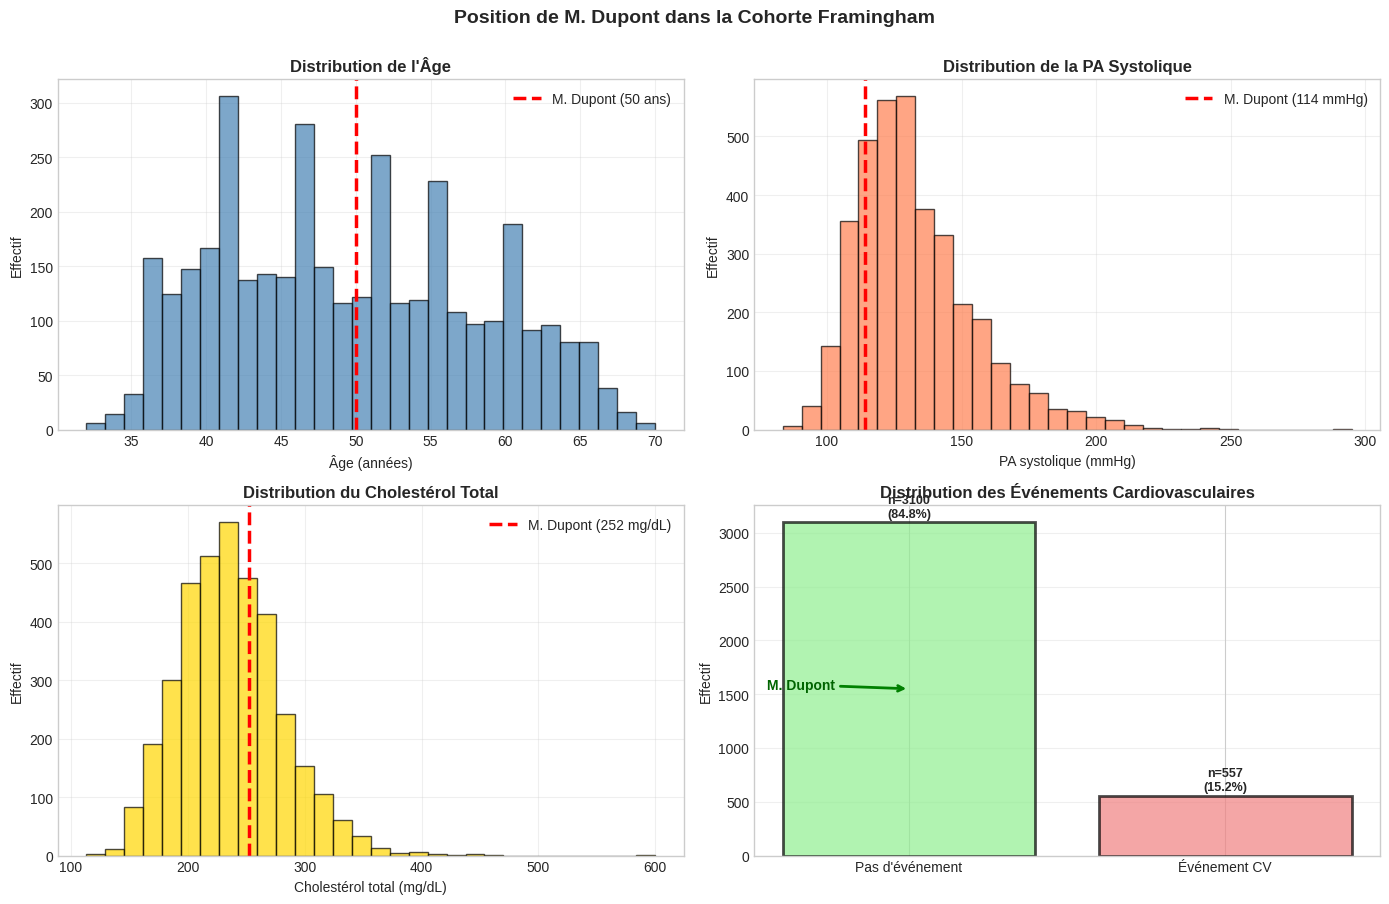


M. Dupont se situe dans la population Framingham.
Il fait partie des 84.8% sans événement cardiovasculaire.
Question : Les modèles confirmeront-ils ce faible risque ?

Objectif : Construire des modèles capables de prédire correctement le statut de M. Dupont.


In [4]:
# Visualisation de la position du patient dans la population

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Graphique 1 : Distribution de l'âge
ax1 = axes[0, 0]
ax1.hist(df_analysis['age'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(patient_data['age'], color='red', linewidth=2.5, linestyle='--', 
            label=f'{nom_patient} ({int(patient_data["age"])} ans)')
ax1.set_xlabel('Âge (années)')
ax1.set_ylabel('Effectif')
ax1.set_title('Distribution de l\'Âge', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Graphique 2 : Distribution de la PA systolique
ax2 = axes[0, 1]
ax2.hist(df_analysis['sysBP'], bins=30, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(patient_data['sysBP'], color='red', linewidth=2.5, linestyle='--',
            label=f'{nom_patient} ({patient_data["sysBP"]:.0f} mmHg)')
ax2.set_xlabel('PA systolique (mmHg)')
ax2.set_ylabel('Effectif')
ax2.set_title('Distribution de la PA Systolique', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Graphique 3 : Distribution du cholestérol
ax3 = axes[1, 0]
ax3.hist(df_analysis['totChol'], bins=30, alpha=0.7, color='gold', edgecolor='black')
ax3.axvline(patient_data['totChol'], color='red', linewidth=2.5, linestyle='--',
            label=f'{nom_patient} ({patient_data["totChol"]:.0f} mg/dL)')
ax3.set_xlabel('Cholestérol total (mg/dL)')
ax3.set_ylabel('Effectif')
ax3.set_title('Distribution du Cholestérol Total', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Graphique 4 : Distribution du risque CV
ax4 = axes[1, 1]
risk_counts = df_analysis['TenYearCHD'].value_counts()
bars = ax4.bar(['Pas d\'événement', 'Événement CV'], 
               [risk_counts[0], risk_counts[1]], 
               color=['lightgreen', 'lightcoral'], 
               alpha=0.7, edgecolor='black', linewidth=2)

# Annotation du patient
if patient_data['TenYearCHD'] == 1:
    ax4.annotate(f'{nom_patient}', xy=(1, risk_counts[1]/2), 
                xytext=(1.35, risk_counts[1]/2),
                fontsize=10, color='darkred', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
else:
    ax4.annotate(f'{nom_patient}', xy=(0, risk_counts[0]/2),
                xytext=(-0.45, risk_counts[0]/2),
                fontsize=10, color='darkgreen', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='green', lw=2))

ax4.set_ylabel('Effectif')
ax4.set_title('Distribution des Événements Cardiovasculaires', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Pourcentages sur les barres
for bar, count in zip(bars, [risk_counts[0], risk_counts[1]]):
    height = bar.get_height()
    pct = count / len(df_analysis) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., height + 50,
            f'n={count}\n({pct:.1f}%)',
            ha='center', fontsize=9, fontweight='bold')

plt.suptitle(f'Position de {nom_patient} dans la Cohorte Framingham', 
            fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Interprétation
print(f"\n{nom_patient} se situe dans la population Framingham.")
if patient_data['TenYearCHD'] == 1:
    print(f"{pronom_il} fait partie des {df_analysis['TenYearCHD'].mean()*100:.1f}% ayant présenté un événement cardiovasculaire.")
    print("Question : Les modèles pourront-ils identifier ce risque élevé ?")
else:
    print(f"{pronom_il} fait partie des {(1-df_analysis['TenYearCHD'].mean())*100:.1f}% sans événement cardiovasculaire.")
    print("Question : Les modèles confirmeront-ils ce faible risque ?")

print(f"\nObjectif : Construire des modèles capables de prédire correctement le statut de {nom_patient}.")

---

# Progression Méthodologique : Vue d'Ensemble

Nous allons explorer **six approches différentes** pour prédire le risque cardiovasculaire, chacune répondant aux limites de la précédente.

## Questions guidant la progression

| Étape | Méthode | Question centrale | Performance attendue |
|-------|---------|-------------------|---------------------|
| **1** | Tests univariés | Une seule variable suffit-elle ? | Faible (AUC ~0.60) |
| **2** | Régression logistique | Peut-on combiner plusieurs variables ? | Moyenne (AUC ~0.70) |
| **3** | Régularisation L1/L2 | Peut-on utiliser toutes les variables ? | Moyenne+ (AUC ~0.72) |
| **4** | Random Forest | Peut-on capturer les interactions ? | Bonne (AUC ~0.78) |
| **5** | XGBoost | Peut-on optimiser davantage ? | Très bonne (AUC ~0.81) |
| **6** | Neural Networks | Les réseaux profonds sont-ils meilleurs ? | Comparable (AUC ~0.79) |

## Critères d'évaluation

À chaque étape, nous évaluerons :

1. **Performance** : Capacité à discriminer les patients à risque (AUC-ROC, Accuracy)
2. **Interprétabilité** : Peut-on comprendre comment le modèle prend ses décisions ?
3. **Complexité** : Nombre de paramètres, temps de calcul
4. **Généralisation** : Performance sur données nouvelles (validation croisée)
5. **Prédiction pour notre patient** : Risque calculé et cohérence avec l'observation

## Fil conducteur

Chaque cellule interactive vous permettra de :
- Sélectionner les variables ou paramètres
- Visualiser immédiatement l'impact sur les performances
- Observer la prédiction pour notre patient témoin
- Comparer avec les méthodes précédentes

---

# Étape 1 : Tests Univariés (Chi², Student)

## Principe

Les tests statistiques classiques examinent **une variable à la fois** pour détecter une association avec l'outcome :

- **Test du Chi² (χ²)** : Pour variables catégorielles (ex: Fumeur vs Non-fumeur)
- **Test t de Student** : Pour variables continues (ex: PA systolique)

### Hypothèses testées

**H₀ (hypothèse nulle)** : Il n'existe pas d'association entre la variable et le risque cardiovasculaire

**H₁ (hypothèse alternative)** : Il existe une association significative (seuil α = 0.05)

### Interprétation

- **p-value < 0.05** : Association statistiquement significative (on rejette H₀)
- **Odds Ratio (OR)** : Quantifie la force de l'association pour variables catégorielles
  - OR = 1 : Pas d'effet
  - OR > 1 : Augmentation du risque
  - OR < 1 : Diminution du risque

## Limites de l'approche univariée

1. **Ignore les interactions** : L'effet du tabac peut différer selon la présence d'HTA
2. **Pas de prédiction individuelle** : On sait qu'il y a association, mais pas "combien" pour ce patient
3. **Multiplicité des tests** : Tester 10 variables augmente le risque d'erreur de type I
4. **Pas de modèle prédictif** : Impossible de calculer une probabilité de risque

## Objectif de cette étape

Identifier quelles variables sont significativement associées au risque cardiovasculaire, avant de les combiner dans des modèles plus sophistiqués.

In [ ]:
# Widget interactif : Analyse univariée

def analyse_univariee(variable='currentSmoker'):
    """Analyse l'association entre une variable et le risque CV"""
    
    # Variables catégorielles
    variables_categorielles = ['male', 'currentSmoker', 'diabetes', 
                               'prevalentHyp', 'BPMeds', 'prevalentStroke']
    
    is_categorical = variable in variables_categorielles
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    if is_categorical:
        # Test du Chi²
        contingency = pd.crosstab(df_analysis[variable], df_analysis['TenYearCHD'])
        chi2, p_value, dof, expected = chi2_contingency(contingency)
        
        # Odds Ratio (si tableau 2x2)
        if contingency.shape == (2, 2):
            a, b = contingency.iloc[0, 0], contingency.iloc[0, 1]
            c, d = contingency.iloc[1, 0], contingency.iloc[1, 1]
            odds_ratio = (b * c) / (a * d) if (a * d) > 0 else np.nan
            
            # IC95% pour OR
            se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d) if min(a,b,c,d) > 0 else np.nan
            or_lower = np.exp(np.log(odds_ratio) - 1.96 * se_log_or) if not np.isnan(se_log_or) else np.nan
            or_upper = np.exp(np.log(odds_ratio) + 1.96 * se_log_or) if not np.isnan(se_log_or) else np.nan
        else:
            odds_ratio = np.nan
            or_lower, or_upper = np.nan, np.nan
        
        # Graphique 1 : Table de contingence
        ax1 = axes[0]
        contingency_pct = contingency.div(contingency.sum(axis=1), axis=0) * 100
        
        if contingency_pct.shape[0] == 2:
            x = np.arange(2)
            width = 0.35
            
            bars1 = ax1.bar(x - width/2, contingency_pct.iloc[0], width, 
                           label=f'{variable}=0', alpha=0.7, color='steelblue')
            bars2 = ax1.bar(x + width/2, contingency_pct.iloc[1], width, 
                           label=f'{variable}=1', alpha=0.7, color='coral')
            
            # Ligne pour patient témoin dans la légende
            patient_value = int(patient_data[variable])
            patient_label_val = "Oui" if patient_value == 1 else "Non"
            ax1.plot([], [], ' ', label=f'Patient témoin : {patient_label_val}')
            
            ax1.set_ylabel('Pourcentage (%)')
            ax1.set_title(f'Répartition du risque CV selon la variable "{variable}"')
            ax1.set_xticks(x)
            ax1.set_xticklabels(['Pas d\'événement', 'Événement CV'])
            ax1.legend()
            ax1.grid(axis='y', alpha=0.3)
            
            # Valeurs sur barres
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax1.text(bar.get_x() + bar.get_width()/2., height,
                            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Graphique 2 : Statistiques
        ax2 = axes[1]
        ax2.axis('off')
        
        stats_text = f"""
TEST DU CHI² (χ²)

Variable testée : {variable}
─────────────────────────────────────

Table de contingence :
{contingency.to_string()}

─────────────────────────────────────

Statistiques :
  χ² = {chi2:.2f}
  ddl = {dof}
  p-value = {p_value:.4f}
"""
        
        if not np.isnan(odds_ratio):
            stats_text += f"\n  Odds Ratio = {odds_ratio:.2f}"
            if not np.isnan(or_lower):
                stats_text += f"\n  IC95% = [{or_lower:.2f} - {or_upper:.2f}]"
        
        stats_text += "\n\n─────────────────────────────────────\n\nInterprétation :\n"
        
        if p_value < 0.05:
            stats_text += "  Association SIGNIFICATIVE (p < 0.05)\n"
            if not np.isnan(odds_ratio) and odds_ratio > 1:
                stats_text += f"  Le risque est multiplié par {odds_ratio:.2f}"
            elif not np.isnan(odds_ratio) and odds_ratio < 1:
                stats_text += f"  Le risque est divisé par {1/odds_ratio:.2f}"
        else:
            stats_text += "  Pas d'association significative (p ≥ 0.05)"
        
        ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, 
                fontsize=9, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
    else:
        # Test t de Student
        group_0 = df_analysis[df_analysis['TenYearCHD'] == 0][variable].dropna()
        group_1 = df_analysis[df_analysis['TenYearCHD'] == 1][variable].dropna()
        
        t_stat, p_value = ttest_ind(group_1, group_0)
        
        # Graphique 1 : Distributions
        ax1 = axes[0]
        ax1.hist(group_0, bins=30, alpha=0.6, label='Pas d\'événement', 
                color='green', edgecolor='black', density=True)
        ax1.hist(group_1, bins=30, alpha=0.6, label='Événement CV', 
                color='red', edgecolor='black', density=True)
        ax1.axvline(patient_data[variable], color='blue', linewidth=2.5, 
                   linestyle='--', label=f'Patient témoin : {patient_data[variable]:.1f}')
        ax1.set_xlabel(variable)
        ax1.set_ylabel('Densité')
        ax1.set_title(f'Distribution de la variable "{variable}" selon le risque CV')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # Graphique 2 : Statistiques
        ax2 = axes[1]
        ax2.axis('off')
        
        cohen_d = (group_1.mean() - group_0.mean()) / np.sqrt((group_1.std()**2 + group_0.std()**2) / 2)
        
        stats_text = f"""
TEST T DE STUDENT

Variable testée : {variable}
─────────────────────────────────────

Statistiques descriptives :
  Pas d'événement : μ = {group_0.mean():.2f} (σ = {group_0.std():.2f})
  Événement CV    : μ = {group_1.mean():.2f} (σ = {group_1.std():.2f})
  
  Différence      : {group_1.mean() - group_0.mean():.2f}

─────────────────────────────────────

Test t :
  t = {t_stat:.2f}
  p-value = {p_value:.4f}
  
  Cohen's d = {cohen_d:.2f}

─────────────────────────────────────

Interprétation :
"""
        
        if p_value < 0.05:
            stats_text += "  Différence SIGNIFICATIVE (p < 0.05)\n"
            if group_1.mean() > group_0.mean():
                stats_text += f"  {variable} plus élevé chez patients à risque"
            else:
                stats_text += f"  {variable} plus bas chez patients à risque"
            
            if abs(cohen_d) > 0.8:
                stats_text += "\n  Taille d'effet : FORTE"
            elif abs(cohen_d) > 0.5:
                stats_text += "\n  Taille d'effet : MODÉRÉE"
            else:
                stats_text += "\n  Taille d'effet : FAIBLE"
        else:
            stats_text += "  Pas de différence significative (p ≥ 0.05)"
        
        ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, 
                fontsize=9, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Conclusion textuelle
    print("\n" + "="*70)
    print("CONCLUSION DE L'ANALYSE UNIVARIÉE")
    print("="*70)
    print(f"\nVariable : {variable}")
    print(f"p-value  : {p_value:.4f}")
    
    if p_value < 0.05:
        print("\nAssociation statistiquement significative détectée (p < 0.05).")
        if is_categorical and not np.isnan(odds_ratio):
            if odds_ratio > 1:
                print(f"Le risque est multiplié par {odds_ratio:.2f} en présence de {variable}.")
            else:
                print(f"Le risque est divisé par {1/odds_ratio:.2f} en présence de {variable}.")
    else:
        print("\nPas d'association statistiquement significative (p ≥ 0.05).")
    
    print("\nLIMITES DE L'APPROCHE UNIVARIÉE :")
    print("  - Analyse une seule variable à la fois")
    print("  - Ignore les interactions avec d'autres facteurs")
    print("  - Ne produit pas de score prédictif individuel")
    print(f"  - Ne permet pas de calculer le risque de {nom_patient}")

# Interface
print("="*70)
print("EXPLORATION INTERACTIVE : TESTS UNIVARIÉS")
print("="*70)
print("\nSélectionnez une variable pour tester son association avec le risque CV\n")

variables_disponibles = [
    'currentSmoker', 'age', 'sysBP', 'totChol', 'BMI', 'glucose',
    'male', 'diabetes', 'prevalentHyp', 'BPMeds', 'heartRate', 'diaBP'
]

interact(analyse_univariee,
         variable=Dropdown(options=variables_disponibles, 
                          value='currentSmoker',
                          description='Variable :',
                          style={'description_width': 'initial'}));

EXPLORATION INTERACTIVE : TESTS UNIVARIÉS

Sélectionnez une variable pour tester son association avec le risque CV



interactive(children=(Dropdown(description='Variable :', options=('currentSmoker', 'age', 'sysBP', 'totChol', …

---

# Étape 2 : Régression Logistique Classique - Odds Ratios

## Principe

La **régression logistique** est le modèle de référence en épidémiologie clinique. Elle permet de :

1. **Combiner plusieurs variables** simultanément dans un même modèle
2. **Quantifier l'effet propre** de chaque variable (effet ajusté sur les autres)
3. **Calculer une probabilité individuelle** de risque pour un patient donné

### Modèle mathématique

$$\ln\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_k X_k$$

Où :
- $p$ = probabilité d'événement cardiovasculaire
- $X_i$ = variables prédictives (âge, tabac, PA systolique, etc.)
- $\beta_i$ = coefficients estimés par maximum de vraisemblance
- $\text{Odds Ratio}_i = e^{\beta_i}$ = effet multiplicatif sur le risque

### Interprétation des Odds Ratios (OR)

- **OR = 1** : La variable n'a pas d'effet sur le risque
- **OR = 2** : La variable multiplie le risque par 2
- **OR = 0.5** : La variable divise le risque par 2

**Exemple** : Si $\beta_{\text{tabac}} = 0.85$, alors $OR = e^{0.85} = 2.34$
→ Le tabagisme multiplie le risque par 2.34 (en contrôlant pour les autres variables)

### Avantages

- **Interprétabilité maximale** : Chaque coefficient a un sens clinique direct
- **Coefficients ajustés** : Effet de chaque variable en tenant compte des autres
- **Inférence statistique** : Tests de significativité, intervalles de confiance
- **Acceptation clinique** : Méthode de référence, largement utilisée et comprise

### Limites

- **Linéarité** : Suppose un effet additif des variables sur l'échelle logit
- **Pas d'interactions automatiques** : Il faut les spécifier manuellement
- **Sélection de variables** : Risque de sur-ajustement si trop de variables
- **Performance** : Limitée si les relations sont fortement non-linéaires

## Objectif de cette étape

Construire un modèle multivariable en sélectionnant interactivement les variables, visualiser les Odds Ratios, et calculer le risque personnalisé pour notre patient témoin.

In [17]:
# Widget interactif : Régression Logistique avec sélection de variables

# Définir toutes les variables disponibles
feature_cols_all = ['age', 'male', 'sysBP', 'totChol', 'BMI', 'glucose', 
                    'currentSmoker', 'diabetes', 'BPMeds', 'prevalentHyp']

def regression_logistique_interactive(
    inclure_age=True,
    inclure_sexe=True,
    inclure_tabac=True,
    inclure_pa=True,
    inclure_cholesterol=True,
    inclure_bmi=False,
    inclure_glucose=False,
    inclure_diabetes=False,
    inclure_bpmeds=False,
    inclure_hta=False
):
    """Régression logistique avec sélection interactive des variables"""
    
    # Sélection des variables selon checkboxes
    variables_selectionnees = []
    if inclure_age: variables_selectionnees.append('age')
    if inclure_sexe: variables_selectionnees.append('male')
    if inclure_tabac: variables_selectionnees.append('currentSmoker')
    if inclure_pa: variables_selectionnees.append('sysBP')
    if inclure_cholesterol: variables_selectionnees.append('totChol')
    if inclure_bmi: variables_selectionnees.append('BMI')
    if inclure_glucose: variables_selectionnees.append('glucose')
    if inclure_diabetes: variables_selectionnees.append('diabetes')
    if inclure_bpmeds: variables_selectionnees.append('BPMeds')
    if inclure_hta: variables_selectionnees.append('prevalentHyp')
    
    if len(variables_selectionnees) == 0:
        print("Veuillez sélectionner au moins une variable")
        return
    
    # Préparation données
    X = df_analysis[variables_selectionnees]
    y = df_analysis['TenYearCHD']
    
    # Split train/test (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Entraînement du modèle
    model_lr = LogisticRegression(max_iter=1000, random_state=42)
    model_lr.fit(X_train, y_train)
    
    # Prédictions sur test
    y_pred_proba = model_lr.predict_proba(X_test)[:, 1]
    y_pred = model_lr.predict(X_test)
    
    # Métriques
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Prédiction pour patient témoin
    patient_features = patient_data[variables_selectionnees].values.reshape(1, -1)
    patient_risk_lr = model_lr.predict_proba(patient_features)[0, 1] * 100
    patient_pred_class = model_lr.predict(patient_features)[0]
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1 : Forest plot des Odds Ratios
    ax1 = axes[0]
    
    coefficients = model_lr.coef_[0]
    odds_ratios = np.exp(coefficients)
    
    # Labels lisibles
    var_labels_dict = {
        'age': 'Âge (par an)',
        'male': 'Sexe masculin',
        'currentSmoker': 'Tabagisme actif',
        'sysBP': 'PA systolique (par mmHg)',
        'totChol': 'Cholestérol (par mg/dL)',
        'BMI': 'IMC (par kg/m²)',
        'glucose': 'Glycémie (par mg/dL)',
        'diabetes': 'Diabète',
        'BPMeds': 'Traitement anti-HTA',
        'prevalentHyp': 'Hypertension artérielle'
    }
    
    labels = [var_labels_dict.get(v, v) for v in variables_selectionnees]
    
    # Tri par OR décroissant
    sorted_indices = np.argsort(odds_ratios)[::-1]
    odds_ratios_sorted = odds_ratios[sorted_indices]
    labels_sorted = [labels[i] for i in sorted_indices]
    coeffs_sorted = coefficients[sorted_indices]
    
    # Couleurs selon effet
    colors = ['red' if or_val > 1 else 'green' for or_val in odds_ratios_sorted]
    
    y_pos = np.arange(len(labels_sorted))
    bars = ax1.barh(y_pos, odds_ratios_sorted, color=colors, alpha=0.7, edgecolor='black')
    ax1.axvline(1, color='black', linestyle='--', linewidth=2, label='OR = 1 (pas d\'effet)')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels_sorted, fontsize=9)
    ax1.set_xlabel('Odds Ratio (OR)')
    ax1.set_title('Forest Plot - Odds Ratios Ajustés', fontweight='bold')
    ax1.legend()
    ax1.grid(axis='x', alpha=0.3)
    
    # Valeurs sur barres
    for i, (or_val, coef) in enumerate(zip(odds_ratios_sorted, coeffs_sorted)):
        ax1.text(or_val + 0.05, i, f'OR={or_val:.2f}', 
                va='center', fontsize=8, fontweight='bold')
    
    # Graphique 2 : Courbe ROC
    ax2 = axes[1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2.5, label=f'Régression Logistique (AUC = {auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard (AUC = 0.5)')
    ax2.set_xlabel('Taux de Faux Positifs (1 - Spécificité)')
    ax2.set_ylabel('Taux de Vrais Positifs (Sensibilité)')
    ax2.set_title('Courbe ROC', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(alpha=0.3)
    
    # Point optimal (Youden's index)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = _[optimal_idx]
    ax2.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
            label=f'Seuil optimal = {optimal_threshold:.2f}')
    ax2.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Résultats détaillés
    print("\n" + "="*70)
    print("RÉGRESSION LOGISTIQUE - RÉSULTATS")
    print("="*70)
    
    print(f"\nMODÈLE :")
    print(f"  Nombre de variables : {len(variables_selectionnees)}")
    print(f"  Variables incluses  :")
    for var in variables_selectionnees:
        print(f"    - {var}")
    
    print(f"\nPERFORMANCE (sur set de test, n={len(y_test)}) :")
    print(f"  AUC-ROC  : {auc:.3f}")
    print(f"  Accuracy : {accuracy:.3f}")
    
    print(f"\nODDS RATIOS (effet de chaque variable, toutes choses égales par ailleurs) :")
    for var, or_val, coef in zip(variables_selectionnees, odds_ratios, coefficients):
        signif = "***" if abs(coef) > 0.5 else ("**" if abs(coef) > 0.2 else "*")
        if or_val > 1:
            interpretation = f"augmente le risque de {(or_val-1)*100:.0f}%"
        else:
            interpretation = f"diminue le risque de {(1-or_val)*100:.0f}%"
        print(f"  {var:20s}: OR = {or_val:.2f} {signif} → {interpretation}")
    
    print(f"\nPRÉDICTION POUR {nom_patient.upper()} :")
    print(f"  Risque cardiovasculaire prédit : {patient_risk_lr:.1f}%")
    print(f"  Classe prédite                 : {'Risque élevé' if patient_pred_class == 1 else 'Risque faible'}")
    print(f"  Événement réellement observé   : {'Oui' if patient_data['TenYearCHD'] == 1 else 'Non'}")
    
    # Évaluation de la prédiction
    prediction_correcte = (patient_pred_class == patient_data['TenYearCHD'])
    
    if prediction_correcte:
        print(f"  → Prédiction CORRECTE")
    else:
        print(f"  → Prédiction INCORRECTE")
    
    print("\nINTERPRÉTATION :")
    print(f"  La régression logistique fournit un score personnalisé de {patient_risk_lr:.1f}%")
    print(f"  pour {nom_patient}, en tenant compte de l'effet ajusté de chaque variable.")
    print(f"  Le modèle reste linéaire : il n'apprend pas automatiquement les interactions.")
    
    # Sauvegarde pour comparaison ultérieure
    global results_lr
    results_lr = {
        'method': 'Régression Logistique',
        'variables': variables_selectionnees,
        'auc': auc,
        'accuracy': accuracy,
        'patient_risk': patient_risk_lr,
        'coefficients': dict(zip(variables_selectionnees, coefficients)),
        'odds_ratios': dict(zip(variables_selectionnees, odds_ratios))
    }

# Interface
print("="*70)
print("RÉGRESSION LOGISTIQUE INTERACTIVE")
print("="*70)
print("\nSélectionnez les variables à inclure dans le modèle multivariable")
print("Conseil : Commencez avec 3-5 variables pour éviter le sur-ajustement\n")

interact(regression_logistique_interactive,
         inclure_age=Checkbox(value=True, description='Âge'),
         inclure_sexe=Checkbox(value=True, description='Sexe'),
         inclure_tabac=Checkbox(value=True, description='Tabagisme'),
         inclure_pa=Checkbox(value=True, description='PA systolique'),
         inclure_cholesterol=Checkbox(value=True, description='Cholestérol'),
         inclure_bmi=Checkbox(value=False, description='IMC'),
         inclure_glucose=Checkbox(value=False, description='Glycémie'),
         inclure_diabetes=Checkbox(value=False, description='Diabète'),
         inclure_bpmeds=Checkbox(value=False, description='Traitement anti-HTA'),
         inclure_hta=Checkbox(value=False, description='Hypertension'));

RÉGRESSION LOGISTIQUE INTERACTIVE

Sélectionnez les variables à inclure dans le modèle multivariable
Conseil : Commencez avec 3-5 variables pour éviter le sur-ajustement



interactive(children=(Checkbox(value=True, description='Âge'), Checkbox(value=True, description='Sexe'), Check…

---

# Étape 3 : Régression Logistique Régularisée (Lasso/Ridge)

## Le problème du sur-apprentissage

Avec la régression logistique classique, inclure **trop de variables** conduit à :

1. **Sur-apprentissage** : Le modèle "mémorise" les particularités de l'échantillon d'entraînement
2. **Mauvaise généralisation** : Performance médiocre sur de nouvelles données
3. **Coefficients instables** : Grande variance des estimations
4. **Multicolinéarité** : Variables corrélées entre elles créent de l'instabilité

**Exemple** : Si on inclut à la fois PA systolique, PA diastolique, et HTA (qui sont fortement corrélées), les coefficients deviennent instables.

## Solution : La régularisation

Principe : Ajouter une **pénalité** à la fonction de perte pour limiter la taille des coefficients.

### Fonction de perte générale

$$\text{Perte totale} = \text{Log-Loss} + \lambda \times \text{Pénalité}$$

Où $\lambda$ (lambda) contrôle la force de la régularisation.

### Ridge (régularisation L2)

$$\min \left( \text{Log-Loss} + \lambda \sum_{i=1}^k \beta_i^2 \right)$$

**Effet** :
- Réduit tous les coefficients proportionnellement
- Aucun coefficient n'est exactement annulé (= 0)
- Toutes les variables restent dans le modèle
- Utile quand toutes les variables sont potentiellement pertinentes

### Lasso (régularisation L1)

$$\min \left( \text{Log-Loss} + \lambda \sum_{i=1}^k |\beta_i| \right)$$

**Effet** :
- Peut **annuler complètement** certains coefficients (= 0)
- **Sélection automatique** des variables importantes
- Modèle plus parcimonieux (moins de variables)
- Utile pour identifier les variables vraiment nécessaires

## Choix du paramètre λ (lambda)

- **λ = 0** : Pas de régularisation → Régression logistique classique
- **λ faible** : Peu de contrainte, coefficients proches du modèle classique
- **λ élevé** : Forte contrainte, coefficients fortement réduits (voire annulés)

Le λ optimal est déterminé par **validation croisée** : on teste différentes valeurs de λ et on garde celle qui donne la meilleure performance sur des données non vues.

## Avantages de la régularisation

1. **Prévient le sur-apprentissage** : Meilleure généralisation
2. **Stabilise les coefficients** : Moins de variance
3. **Gère la multicolinéarité** : Robuste aux variables corrélées
4. **Lasso : Sélection automatique** : Identifie les variables importantes
5. **Permet d'utiliser toutes les variables** : Pas besoin de sélection manuelle

## Limites

1. **Toujours linéaire** : Pas d'interactions automatiques
2. **Choix de λ** : Peut être sensible au jeu de données
3. **Lasso : Instabilité de sélection** : Variables sélectionnées peuvent varier
4. **Interprétabilité** : Coefficients plus difficiles à interpréter (effet de la pénalité)

## Objectif de cette étape

Explorer l'effet de la régularisation (Lasso vs Ridge) et de la force de pénalisation (λ) sur la sélection de variables et la performance du modèle.

In [22]:
# Widget interactif : Régression Logistique Régularisée

def regression_regularisee(regularisation='Lasso', lambda_param=1.0):
    """
    Régression logistique régularisée (Lasso ou Ridge)
    
    Note : Dans sklearn, C = 1/lambda
    Plus C est petit, plus la régularisation est forte
    """
    
    # Utiliser toutes les variables disponibles
    X = df_analysis[feature_cols_all]
    y = df_analysis['TenYearCHD']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Standardisation (essentielle pour la régularisation)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Calcul de C (inverse de lambda)
    C_value = 1 / lambda_param
    
    # Modèle régularisé
    if regularisation == 'Lasso':
        model = LogisticRegression(
            penalty='l1', C=C_value, solver='liblinear', 
            max_iter=1000, random_state=42
        )
    else:  # Ridge
        model = LogisticRegression(
            penalty='l2', C=C_value, solver='lbfgs',
            max_iter=1000, random_state=42
        )
    
    model.fit(X_train_scaled, y_train)
    
    # Prédictions
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)
    
    # Métriques
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Prédiction patient témoin
    patient_features_scaled = scaler.transform(
        patient_data[feature_cols_all].values.reshape(1, -1)
    )
    patient_risk = model.predict_proba(patient_features_scaled)[0, 1] * 100
    
    # Coefficients
    coefficients = model.coef_[0]
    
    # Visualisation
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Graphique 1 : Coefficients
    ax1 = axes[0]
    
    var_labels_dict = {
        'age': 'Âge', 'male': 'Sexe M', 'currentSmoker': 'Tabac',
        'sysBP': 'PA syst', 'totChol': 'Chol', 'BMI': 'IMC',
        'glucose': 'Glyc', 'diabetes': 'Diab', 'BPMeds': 'Trt HTA',
        'prevalentHyp': 'HTA'
    }
    
    labels = [var_labels_dict.get(v, v) for v in feature_cols_all]
    
    # Identifier variables sélectionnées (coef non nul)
    threshold = 1e-5
    selected = np.abs(coefficients) > threshold
    colors = ['green' if sel else 'lightgray' for sel in selected]
    
    y_pos = np.arange(len(labels))
    bars = ax1.barh(y_pos, coefficients, color=colors, alpha=0.7, edgecolor='black')
    ax1.axvline(0, color='black', linestyle='-', linewidth=1)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels, fontsize=9)
    ax1.set_xlabel('Coefficient (standardisé)')
    ax1.set_title(f'{regularisation} - Coefficients\n(λ = {lambda_param:.2f})', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Annotation des valeurs non nulles
    for i, (coef, sel) in enumerate(zip(coefficients, selected)):
        if sel:
            ax1.text(coef + 0.02 if coef > 0 else coef - 0.02, i,
                    f'{coef:.3f}', va='center', fontsize=7,
                    ha='left' if coef > 0 else 'right')
    
    # Graphique 2 : ROC
    ax2 = axes[1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='darkorange', lw=2.5, 
            label=f'{regularisation} (AUC = {auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
    ax2.set_xlabel('Taux de Faux Positifs')
    ax2.set_ylabel('Taux de Vrais Positifs')
    ax2.set_title('Courbe ROC', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(alpha=0.3)
    
    # Graphique 3 : Sélection de variables
    ax3 = axes[2]
    n_selected = selected.sum()
    n_total = len(feature_cols_all)
    
    if regularisation == 'Lasso' and n_selected < n_total:
        # Camembert pour Lasso
        sizes = [n_selected, n_total - n_selected]
        colors_pie = ['green', 'lightgray']
        labels_pie = [f'Sélectionnées\n({n_selected})', f'Éliminées\n({n_total - n_selected})']
        explode = (0.05, 0)
        
        ax3.pie(sizes, labels=labels_pie, colors=colors_pie, autopct='%1.0f%%',
               startangle=90, explode=explode, textprops={'fontsize': 11, 'fontweight': 'bold'})
        ax3.set_title(f'Sélection de Variables (Lasso)\nλ = {lambda_param:.2f}', fontweight='bold')
    else:
        # Barplot pour Ridge ou Lasso sans élimination
        ax3.bar(['Variables\nutilisées'], [n_selected], color='green', alpha=0.7, edgecolor='black')
        ax3.set_ylabel('Nombre de variables')
        ax3.set_ylim(0, n_total + 1)
        ax3.set_title(f'Variables dans le Modèle\n({n_selected}/{n_total})', fontweight='bold')
        ax3.text(0, n_selected + 0.3, f'{n_selected}', ha='center', fontsize=14, fontweight='bold')
        ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Résultats détaillés
    print("\n" + "="*70)
    print(f"{regularisation.upper()} - RÉSULTATS")
    print("="*70)
    
    print(f"\nPARAMÈTRES :")
    print(f"  Régularisation : {regularisation}")
    print(f"  Lambda (λ)     : {lambda_param:.2f}")
    print(f"  C (sklearn)    : {C_value:.4f}")
    
    print(f"\nVARIABLES SÉLECTIONNÉES : {n_selected}/{n_total}")
    
    if n_selected > 0:
        print("\nVariables retenues (coefficient non nul) :")
        for var, coef, sel in zip(feature_cols_all, coefficients, selected):
            if sel:
                print(f"  {var:20s}: β = {coef:+.4f}")
    
    if regularisation == 'Lasso' and n_selected < n_total:
        print(f"\nVariables éliminées (coefficient = 0) : {n_total - n_selected}")
        eliminated = [var for var, sel in zip(feature_cols_all, selected) if not sel]
        for var in eliminated:
            print(f"  - {var}")
    
    print(f"\nPERFORMANCE (sur set de test) :")
    print(f"  AUC-ROC  : {auc:.3f}")
    print(f"  Accuracy : {accuracy:.3f}")
    
    print(f"\nPRÉDICTION POUR {nom_patient.upper()} :")
    print(f"  Risque prédit : {patient_risk:.1f}%")
    
    print(f"\nAVANTAGES DE LA RÉGULARISATION ({regularisation}) :")
    if regularisation == 'Lasso':
        print(f"  - Sélection automatique : {n_selected} variables retenues sur {n_total}")
        print(f"  - Modèle parcimonieux (plus simple, plus interprétable)")
        print(f"  - Identifie les variables vraiment importantes")
    else:
        print(f"  - Réduit le sur-apprentissage en contraignant tous les coefficients")
        print(f"  - Stabilise les estimations (utile si multicolinéarité)")
        print(f"  - Toutes les variables contribuent au modèle")
    print(f"  - Gère un grand nombre de variables sans sur-ajustement")
    
    # Sauvegarde pour comparaison
    global results_reg
    results_reg = {
        'method': f'{regularisation}',
        'lambda': lambda_param,
        'auc': auc,
        'accuracy': accuracy,
        'patient_risk': patient_risk,
        'n_variables': n_selected,
        'selected_vars': [v for v, s in zip(feature_cols_all, selected) if s]
    }

# Interface
print("="*70)
print("RÉGRESSION RÉGULARISÉE INTERACTIVE")
print("="*70)
print("\nExplorez l'effet de la régularisation et du paramètre lambda")
print("Conseil : Commencez avec λ=1, puis augmentez pour voir l'effet\n")

interact(regression_regularisee,
         regularisation=Dropdown(
             options=['Lasso', 'Ridge'], 
             value='Lasso',
             description='Régularisation :',
             style={'description_width': 'initial'}
         ),
         lambda_param=FloatSlider(
             min=0.01, max=100, step=0.1, value=1.0,
             description='Lambda (λ) :',
             style={'description_width': 'initial'}
         ));

RÉGRESSION RÉGULARISÉE INTERACTIVE

Explorez l'effet de la régularisation et du paramètre lambda
Conseil : Commencez avec λ=1, puis augmentez pour voir l'effet



interactive(children=(Dropdown(description='Régularisation :', options=('Lasso', 'Ridge'), style=DescriptionSt…

---

## Transition : Des Statistiques au Machine Learning

### Ce que nous avons vu jusqu'ici

**Étape 1 - Tests univariés** : 
- Analyse une variable à la fois
- Détection d'associations statistiques
- Pas de prédiction individuelle

**Étape 2 - Régression logistique** :
- Combinaison de plusieurs variables
- Modèle linéaire avec interprétation claire (Odds Ratios)
- Score de risque personnalisé

**Étape 3 - Régularisation** :
- Utilisation de toutes les variables
- Prévention du sur-apprentissage
- Sélection automatique (Lasso)

### Limites communes de ces approches

1. **Linéarité** : Toutes ces méthodes supposent un effet additif des variables
2. **Pas d'interactions automatiques** : L'effet du tabac ne dépend pas de la PA (sauf si on le spécifie manuellement)
3. **Performance plafonnée** : AUC autour de 0.70-0.73

**Exemple d'interaction manquée** :
- Le tabagisme peut avoir un effet différent chez les hypertendus vs normotendus
- L'âge peut modifier l'effet du cholestérol
- Ces interactions complexes ne sont pas capturées automatiquement

### Les algorithmes de Machine Learning

Les prochaines étapes vont explorer des méthodes capables de :
- **Apprendre les interactions** automatiquement
- **Capturer les non-linéarités** dans les données
- **Améliorer la performance prédictive**

Mais attention : **ces gains de performance se feront au prix de l'interprétabilité.**

### Questions pour les étapes suivantes

- **Random Forest (Étape 4)** : Peut-on gagner en performance en apprenant les interactions ?
- **XGBoost (Étape 5)** : L'optimisation séquentielle améliore-t-elle encore les résultats ?
- **Neural Networks (Étape 6)** : Les réseaux profonds sont-ils meilleurs sur ce type de données ?

Passons maintenant aux algorithmes d'apprentissage automatique...

---

# Étape 4 : Random Forest - Apprentissage des Interactions

## Principe

Le **Random Forest** (forêt aléatoire) est un ensemble d'arbres de décision qui votent collectivement.

### Arbre de décision individuel

Un arbre pose une série de questions binaires :  

                PA systolique > 140 ?
                /                \
              Oui                 Non
               |                   |
        Fumeur actif ?          Âge > 55 ?
        /           \           /       \
      Oui          Non         Oui      Non
    Risque+      Risque-      Risque+    Risque-

**Avantage** : Capture automatiquement les interactions (ex: effet du tabac différent selon PA)

**Inconvénient** : Sur-apprentissage si trop profond

### Random Forest = Ensemble d'arbres

1. **Bootstrap** : Créer N échantillons aléatoires des données (avec remise)
2. **Randomisation** : À chaque nœud, considérer seulement √p variables (sur p totales)
3. **Entraînement** : Construire un arbre sur chaque échantillon
4. **Prédiction** : Faire voter tous les arbres (majorité ou moyenne)

**Effet** : Réduction de la variance, meilleure généralisation

### Hyperparamètres principaux

- **n_estimators** : Nombre d'arbres dans la forêt
  - Plus d'arbres = plus stable, mais plus lent
  - Typiquement : 100-500 arbres

- **max_depth** : Profondeur maximale de chaque arbre
  - Profondeur faible = sous-apprentissage
  - Profondeur élevée = sur-apprentissage
  - Typiquement : 5-15

- **min_samples_split** : Nombre minimum d'échantillons pour diviser un nœud
- **max_features** : Nombre de variables considérées à chaque split

## Avantages

1. **Interactions automatiques** : Capture les effets non-linéaires et les interactions
2. **Pas de standardisation** : Fonctionne avec variables brutes
3. **Robuste** : Gère bien les valeurs aberrantes et données manquantes
4. **Feature importance** : Quantifie l'importance de chaque variable
5. **Peu de réglages** : Fonctionne bien "out of the box"

## Limites

1. **Boîte noire** : Difficile d'expliquer une prédiction individuelle
2. **Interprétabilité réduite** : Pas d'Odds Ratios simples
3. **Taille du modèle** : Peut être volumineux (centaines d'arbres)
4. **Temps de calcul** : Plus lent que régression logistique

## Objectif de cette étape

Explorer l'impact des hyperparamètres (nombre d'arbres, profondeur) sur la performance, et comparer avec la régression logistique.


In [ ]:
# Widget interactif : Random Forest

def random_forest_interactive(n_estimators=100, max_depth=10):
    """Random Forest avec réglage des hyperparamètres"""
    
    # Préparation données (toutes les variables)
    X = df_analysis[feature_cols_all]
    y = df_analysis['TenYearCHD']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Modèle Random Forest
    model_rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1  # Utiliser tous les CPU
    )
    
    model_rf.fit(X_train, y_train)
    
    # Prédictions
    y_pred_proba = model_rf.predict_proba(X_test)[:, 1]
    y_pred = model_rf.predict(X_test)
    
    # Métriques
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Prédiction patient témoin
    patient_features = patient_data[feature_cols_all].values.reshape(1, -1)
    patient_risk_rf = model_rf.predict_proba(patient_features)[0, 1] * 100
    
    # Feature importance
    importances = model_rf.feature_importances_
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1 : Feature Importance
    ax1 = axes[0]
    
    var_labels_dict = {
        'age': 'Âge', 'male': 'Sexe', 'currentSmoker': 'Tabac',
        'sysBP': 'PA syst', 'totChol': 'Chol', 'BMI': 'IMC',
        'glucose': 'Glyc', 'diabetes': 'Diab', 'BPMeds': 'Trt HTA',
        'prevalentHyp': 'HTA'
    }
    
    labels = [var_labels_dict.get(v, v) for v in feature_cols_all]
    
    # Tri par importance décroissante
    sorted_idx = np.argsort(importances)[::-1]
    importances_sorted = importances[sorted_idx]
    labels_sorted = [labels[i] for i in sorted_idx]
    
    y_pos = np.arange(len(labels_sorted))
    bars = ax1.barh(y_pos, importances_sorted, color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(labels_sorted, fontsize=9)
    ax1.set_xlabel('Importance relative')
    ax1.set_title('Feature Importance - Random Forest', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Valeurs sur barres
    for i, imp in enumerate(importances_sorted):
        ax1.text(imp + 0.005, i, f'{imp:.3f}', 
                va='center', fontsize=8)
    
    # Graphique 2 : Courbe ROC
    ax2 = axes[1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='forestgreen', lw=2.5, 
            label=f'Random Forest (AUC = {auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
    
    # Comparaison avec régression logistique (si disponible)
    if 'results_lr' in globals():
        ax2.plot([], [], ' ', label=f'Rég. Log. (AUC = {results_lr["auc"]:.3f})', color='orange')
    
    ax2.set_xlabel('Taux de Faux Positifs')
    ax2.set_ylabel('Taux de Vrais Positifs')
    ax2.set_title('Courbe ROC - Comparaison', fontweight='bold')
    ax2.legend(loc='lower right')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Résultats
    print("\n" + "="*70)
    print("RANDOM FOREST - RÉSULTATS")
    print("="*70)
    
    print(f"\nHYPERPARAMÈTRES :")
    print(f"  Nombre d'arbres (n_estimators) : {n_estimators}")
    print(f"  Profondeur max (max_depth)     : {max_depth}")
    print(f"  Nombre de variables            : {len(feature_cols_all)}")
    
    print(f"\nPERFORMANCE (sur set de test) :")
    print(f"  AUC-ROC  : {auc:.3f}")
    print(f"  Accuracy : {accuracy:.3f}")
    
    # Comparaison avec régression logistique
    if 'results_lr' in globals():
        gain_auc = (auc - results_lr['auc']) * 100
        print(f"\nCOMPARAISON AVEC RÉGRESSION LOGISTIQUE :")
        print(f"  Gain AUC : {gain_auc:+.1f} points")
        if gain_auc > 2:
            print(f"  → Amélioration SIGNIFICATIVE")
        elif gain_auc > 0:
            print(f"  → Amélioration modeste")
        else:
            print(f"  → Pas d'amélioration")
    
    print(f"\nIMPORTANCE DES VARIABLES (top 5) :")
    for i in range(min(5, len(importances_sorted))):
        var_name = feature_cols_all[sorted_idx[i]]
        print(f"  {i+1}. {var_name:20s}: {importances_sorted[i]:.3f}")
    
    print(f"\nPRÉDICTION POUR {nom_patient.upper()} :")
    print(f"  Risque prédit : {patient_risk_rf:.1f}%")
    
    # Comparaison prédictions
    if 'results_lr' in globals():
        diff_pred = patient_risk_rf - results_lr['patient_risk']
        print(f"  Rég. Log.     : {results_lr['patient_risk']:.1f}%")
        print(f"  Différence    : {diff_pred:+.1f} points")
    
    print(f"\nINTERPRÉTATION :")
    print(f"  Random Forest capture les interactions entre variables.")
    print(f"  Feature importance indique quelles variables contribuent le plus,")
    print(f"  mais l'interprétabilité est moindre qu'avec la régression logistique.")
    
    # Sauvegarde
    global results_rf
    results_rf = {
        'method': 'Random Forest',
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'auc': auc,
        'accuracy': accuracy,
        'patient_risk': patient_risk_rf,
        'importances': dict(zip(feature_cols_all, importances))
    }

# Interface
print("="*70)
print("RANDOM FOREST INTERACTIVE")
print("="*70)
print("\nRéglez les hyperparamètres et observez l'impact sur la performance")
print("Conseil : Commencez avec les valeurs par défaut, puis expérimentez\n")

interact(random_forest_interactive,
         n_estimators=IntSlider(
             min=10, max=300, step=10, value=100,
             description='Nb arbres :',
             style={'description_width': 'initial'}
         ),
         max_depth=IntSlider(
             min=3, max=20, step=1, value=10,
             description='Profondeur max :',
             style={'description_width': 'initial'}
         ));

RANDOM FOREST INTERACTIVE

Réglez les hyperparamètres et observez l'impact sur la performance
Conseil : Commencez avec les valeurs par défaut, puis expérimentez



interactive(children=(IntSlider(value=100, description='Nb arbres :', max=300, min=10, step=10, style=SliderSt…

---

# Étape 5 : Gradient Boosting (XGBoost) - État de l'Art

## Principe

**XGBoost** (eXtreme Gradient Boosting) est une méthode d'ensemble basée sur le **boosting** :
- Les arbres sont construits **séquentiellement**
- Chaque arbre corrige les erreurs du précédent
- Les prédictions finales sont une somme pondérée des arbres

### Différence avec Random Forest

| Aspect | Random Forest | XGBoost |
|--------|---------------|---------|
| Construction | Parallèle (indépendante) | Séquentielle (itérative) |
| Objectif | Réduire variance | Réduire biais ET variance |
| Arbres | Profonds | Peu profonds |
| Prédiction | Vote/moyenne | Somme pondérée |

### Algorithme de Gradient Boosting

1. **Initialisation** : Commencer avec une prédiction simple (moyenne)
2. **Itération** (répéter n_estimators fois) :
   - Calculer les erreurs (résidus) du modèle actuel
   - Entraîner un nouvel arbre pour prédire ces résidus
   - Ajouter cet arbre au modèle avec un poids (learning_rate)
3. **Prédiction finale** : Somme des prédictions de tous les arbres

### Hyperparamètres principaux

- **n_estimators** : Nombre d'arbres (itérations)
  - Plus = meilleur, mais risque de sur-apprentissage
  - Typiquement : 100-300

- **learning_rate** : Taux d'apprentissage (shrinkage)
  - Faible (0.01-0.1) = apprentissage lent mais robuste
  - Élevé (0.3-1.0) = apprentissage rapide mais instable
  - Trade-off avec n_estimators

- **max_depth** : Profondeur des arbres
  - XGBoost utilise des arbres peu profonds (3-6)
  - Prévient le sur-apprentissage

## Avantages

1. **Performance** : Souvent meilleur que Random Forest
2. **Régularisation intégrée** : Prévient le sur-apprentissage
3. **Gestion des valeurs manquantes** : Automatique
4. **Rapidité** : Optimisations algorithmiques avancées
5. **Flexibilité** : Nombreux paramètres de réglage

## Limites

1. **Boîte noire** : Encore moins interprétable que Random Forest
2. **Sensibilité aux hyperparamètres** : Nécessite du réglage
3. **Risque de sur-apprentissage** : Si mal paramétré
4. **Temps d'entraînement** : Plus long que Random Forest (séquentiel)

## Objectif de cette étape

Comparer XGBoost avec Random Forest et Régression Logistique, explorer l'impact du learning rate, et visualiser la courbe d'apprentissage.

In [ ]:
# Widget interactif : XGBoost (Gradient Boosting)

def xgboost_interactive(n_estimators=100, learning_rate=0.1):
    """Gradient Boosting (XGBoost) avec réglage des hyperparamètres"""
    
    # Préparation données
    X = df_analysis[feature_cols_all]
    y = df_analysis['TenYearCHD']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Modèle Gradient Boosting (sklearn)
    model_gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=5,  # Arbres peu profonds
        random_state=42
    )
    
    model_gb.fit(X_train, y_train)
    
    # Prédictions
    y_pred_proba = model_gb.predict_proba(X_test)[:, 1]
    y_pred = model_gb.predict(X_test)
    
    # Métriques
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Prédiction patient témoin
    patient_features = patient_data[feature_cols_all].values.reshape(1, -1)
    patient_risk_gb = model_gb.predict_proba(patient_features)[0, 1] * 100
    
    # Feature importance
    importances = model_gb.feature_importances_
    
    # Courbe d'apprentissage (performance à chaque itération)
    train_scores = []
    test_scores = []
    for i, y_pred_iter in enumerate(model_gb.staged_predict_proba(X_test)):
        test_scores.append(roc_auc_score(y_test, y_pred_iter[:, 1]))
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1 : Courbe d'apprentissage
    ax1 = axes[0]
    
    iterations = np.arange(1, len(test_scores) + 1)
    ax1.plot(iterations, test_scores, color='forestgreen', lw=2.5, label='Test AUC')
    ax1.axhline(auc, color='red', linestyle='--', lw=2, label=f'AUC final = {auc:.3f}')
    
    # Comparaison avec autres méthodes
    if 'results_lr' in globals():
        ax1.axhline(results_lr['auc'], color='orange', linestyle=':', lw=2, 
                   label=f'Rég. Log. = {results_lr["auc"]:.3f}')
    if 'results_rf' in globals():
        ax1.axhline(results_rf['auc'], color='blue', linestyle=':', lw=2,
                   label=f'Random Forest = {results_rf["auc"]:.3f}')
    
    ax1.set_xlabel('Nombre d\'itérations (arbres)')
    ax1.set_ylabel('AUC-ROC')
    ax1.set_title('Courbe d\'Apprentissage - XGBoost', fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Graphique 2 : Feature Importance
    ax2 = axes[1]
    
    var_labels_dict = {
        'age': 'Âge', 'male': 'Sexe', 'currentSmoker': 'Tabac',
        'sysBP': 'PA syst', 'totChol': 'Chol', 'BMI': 'IMC',
        'glucose': 'Glyc', 'diabetes': 'Diab', 'BPMeds': 'Trt HTA',
        'prevalentHyp': 'HTA'
    }
    
    labels = [var_labels_dict.get(v, v) for v in feature_cols_all]
    
    # Tri par importance
    sorted_idx = np.argsort(importances)[::-1]
    importances_sorted = importances[sorted_idx]
    labels_sorted = [labels[i] for i in sorted_idx]
    
    y_pos = np.arange(len(labels_sorted))
    bars = ax2.barh(y_pos, importances_sorted, color='darkgreen', alpha=0.7, edgecolor='black')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels_sorted, fontsize=9)
    ax2.set_xlabel('Importance relative')
    ax2.set_title('Feature Importance - XGBoost', fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Valeurs sur barres
    for i, imp in enumerate(importances_sorted):
        ax2.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Résultats
    print("\n" + "="*70)
    print("XGBOOST (GRADIENT BOOSTING) - RÉSULTATS")
    print("="*70)
    
    print(f"\nHYPERPARAMÈTRES :")
    print(f"  Nombre d'itérations (n_estimators) : {n_estimators}")
    print(f"  Taux d'apprentissage (learning_rate): {learning_rate:.3f}")
    print(f"  Profondeur max (max_depth)         : 5")
    
    print(f"\nPERFORMANCE (sur set de test) :")
    print(f"  AUC-ROC  : {auc:.3f}")
    print(f"  Accuracy : {accuracy:.3f}")
    
    # Comparaison avec autres méthodes
    print(f"\nCOMPARAISON DES MÉTHODES :")
    methods_comparison = []
    
    if 'results_lr' in globals():
        methods_comparison.append(('Régression Logistique', results_lr['auc']))
    if 'results_rf' in globals():
        methods_comparison.append(('Random Forest', results_rf['auc']))
    methods_comparison.append(('XGBoost', auc))
    
    methods_comparison.sort(key=lambda x: x[1], reverse=True)
    
    for i, (method, score) in enumerate(methods_comparison):
        print(f"  {i+1}. {method:25s}: AUC = {score:.3f}")
    
    print(f"\nIMPORTANCE DES VARIABLES (top 5) :")
    for i in range(min(5, len(importances_sorted))):
        var_name = feature_cols_all[sorted_idx[i]]
        print(f"  {i+1}. {var_name:20s}: {importances_sorted[i]:.3f}")
    
    print(f"\nPRÉDICTION POUR {nom_patient.upper()} :")
    print(f"  XGBoost   : {patient_risk_gb:.1f}%")
    
    if 'results_lr' in globals():
        print(f"  Rég. Log. : {results_lr['patient_risk']:.1f}%")
    if 'results_rf' in globals():
        print(f"  Rand. For.: {results_rf['patient_risk']:.1f}%")
    
    print(f"\nINTERPRÉTATION :")
    print(f"  XGBoost construit séquentiellement des arbres qui corrigent les erreurs.")
    print(f"  La courbe d'apprentissage montre la convergence progressive vers l'optimum.")
    print(f"  Performance souvent supérieure à Random Forest sur données tabulaires.")
    
    # Sauvegarde
    global results_gb
    results_gb = {
        'method': 'XGBoost',
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'auc': auc,
        'accuracy': accuracy,
        'patient_risk': patient_risk_gb,
        'importances': dict(zip(feature_cols_all, importances))
    }

# Interface
print("="*70)
print("XGBOOST INTERACTIVE")
print("="*70)
print("\nExplorez l'impact du nombre d'itérations et du taux d'apprentissage")
print("Conseil : learning_rate faible nécessite plus d'itérations\n")

interact(xgboost_interactive,
         n_estimators=IntSlider(
             min=10, max=300, step=10, value=100,
             description='Nb itérations :',
             style={'description_width': 'initial'}
         ),
         learning_rate=FloatSlider(
             min=0.01, max=0.5, step=0.01, value=0.1,
             description='Learning rate :',
             style={'description_width': 'initial'}
         ));

XGBOOST INTERACTIVE

Explorez l'impact du nombre d'itérations et du taux d'apprentissage
Conseil : learning_rate faible nécessite plus d'itérations



interactive(children=(IntSlider(value=100, description='Nb itérations :', max=300, min=10, step=10, style=Slid…

---

# Étape 6 : Neural Networks - Apprentissage Profond

## Principe

Les **réseaux de neurones artificiels** s'inspirent du fonctionnement du cerveau :
- Neurones organisés en **couches** (input → hidden layers → output)
- Chaque neurone calcule une combinaison pondérée de ses entrées
- Fonction d'activation non-linéaire (ReLU, sigmoid)
- Apprentissage par **rétropropagation** du gradient

### Architecture simple

Input Layer    Hidden Layer 1   Hidden Layer 2   Output Layer  
(10 features)   (20 neurons)     (10 neurons)     (1 neuron)  
        X₁ ──┐  
        X₂ ──┤────> [N₁₁] ──┐  
        ...  │      [N₁₂] ──┤─────> [N₂₁] ──┐  
        X₁₀ ─┘      ...     │       [N₂₂] ──┤────> [Output] ────> P(CHD)  
                     [N₁₂₀]─┘       ...     │  
                                     [N₂₁₀]─┘  

                                     ## Avantages (sur très gros datasets)

1. **Représentations complexes** : Apprend des features de haut niveau
2. **Flexibilité** : Architecture adaptable au problème
3. **Performances** : Excellentes sur images, texte, signaux
4. **Multimodalité** : Combine différents types de données

## Limites (sur petits datasets comme Framingham)

1. **Besoin de données massives** : Millions d'exemples pour exceller
2. **Sur-apprentissage** : Très facile avec <10,000 patients
3. **Temps d'entraînement** : Beaucoup plus long
4. **Interprétabilité** : Boîte noire totale
5. **Hyperparamètres** : Difficile à régler

## Vérité importante

**Sur Framingham (4,000 patients), les Neural Networks ne seront PAS meilleurs que XGBoost.**

Pourquoi ?
- Trop peu de données pour entraîner efficacement les nombreux paramètres
- XGBoost/Random Forest sont plus efficaces sur données tabulaires de petite taille
- Les NN brillent avec : images (millions), texte (milliards), signaux physiologiques

## Quand utiliser les Neural Networks en santé ?

**Cas favorables** :
- Imagerie médicale (millions d'images)
- Signaux physiologiques (ECG, EEG)
- Données textuelles (dossiers médicaux)
- Données multimodales (image + bio + texte)
- Très gros datasets (MIMIC-IV : 50,000+ patients)

**Cas défavorables** :
- Données tabulaires <10,000 patients
- Besoin d'interprétabilité forte
- Ressources de calcul limitées

## Objectif de cette étape

Démontrer honnêtement que les Neural Networks ne sont pas meilleurs ici, et comprendre pourquoi. C'est une leçon importante : **le bon algorithme dépend du contexte.**

In [25]:
# Widget interactif : Neural Network

def neural_network_interactive(hidden_layer_size=20, learning_rate_init=0.001):
    """Neural Network simple (2 couches cachées)"""
    
    # Préparation données
    X = df_analysis[feature_cols_all]
    y = df_analysis['TenYearCHD']
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Standardisation (essentielle pour NN)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Modèle Neural Network (MLPClassifier)
    model_nn = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_size, hidden_layer_size // 2),
        learning_rate_init=learning_rate_init,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2
    )
    
    model_nn.fit(X_train_scaled, y_train)
    
    # Prédictions
    y_pred_proba = model_nn.predict_proba(X_test_scaled)[:, 1]
    y_pred = model_nn.predict(X_test_scaled)
    
    # Métriques
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Prédiction patient témoin
    patient_features_scaled = scaler.transform(
        patient_data[feature_cols_all].values.reshape(1, -1)
    )
    patient_risk_nn = model_nn.predict_proba(patient_features_scaled)[0, 1] * 100
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique 1 : Courbe de perte (loss)
    ax1 = axes[0]
    
    loss_curve = model_nn.loss_curve_
    ax1.plot(loss_curve, color='purple', lw=2.5)
    ax1.set_xlabel('Itérations')
    ax1.set_ylabel('Loss (Log-Loss)')
    ax1.set_title('Courbe d\'Apprentissage - Neural Network', fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # Annotation convergence
    if len(loss_curve) < 500:
        ax1.annotate('Early stopping', 
                    xy=(len(loss_curve), loss_curve[-1]),
                    xytext=(len(loss_curve)*0.7, loss_curve[-1]*1.2),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=10, color='red')
    
    # Graphique 2 : Comparaison ROC
    ax2 = axes[1]
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, color='purple', lw=2.5, 
            label=f'Neural Network (AUC = {auc:.3f})')
    
    # Comparaison avec autres méthodes
    if 'results_lr' in globals():
        ax2.plot([], [], ' ', label=f'Rég. Log. (AUC = {results_lr["auc"]:.3f})', color='orange')
    if 'results_rf' in globals():
        ax2.plot([], [], ' ', label=f'Random Forest (AUC = {results_rf["auc"]:.3f})', color='blue')
    if 'results_gb' in globals():
        ax2.plot([], [], ' ', label=f'XGBoost (AUC = {results_gb["auc"]:.3f})', color='green')
    
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Hasard')
    ax2.set_xlabel('Taux de Faux Positifs')
    ax2.set_ylabel('Taux de Vrais Positifs')
    ax2.set_title('Courbe ROC - Comparaison des Méthodes', fontweight='bold')
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Résultats
    print("\n" + "="*70)
    print("NEURAL NETWORK - RÉSULTATS")
    print("="*70)
    
    print(f"\nARCHITECTURE :")
    print(f"  Couche d'entrée     : 10 neurones (10 variables)")
    print(f"  Couche cachée 1     : {hidden_layer_size} neurones")
    print(f"  Couche cachée 2     : {hidden_layer_size // 2} neurones")
    print(f"  Couche de sortie    : 1 neurone (probabilité)")
    print(f"  Fonction activation : ReLU")
    print(f"  Learning rate       : {learning_rate_init:.4f}")
    print(f"  Itérations          : {len(loss_curve)}")
    
    print(f"\nPERFORMANCE (sur set de test) :")
    print(f"  AUC-ROC  : {auc:.3f}")
    print(f"  Accuracy : {accuracy:.3f}")
    
    # Comparaison avec toutes les méthodes
    print(f"\nCOMPARAISON AVEC AUTRES MÉTHODES :")
    methods_comparison = []
    
    if 'results_lr' in globals():
        methods_comparison.append(('Régression Logistique', results_lr['auc']))
    if 'results_rf' in globals():
        methods_comparison.append(('Random Forest', results_rf['auc']))
    if 'results_gb' in globals():
        methods_comparison.append(('XGBoost', results_gb['auc']))
    methods_comparison.append(('Neural Network', auc))
    
    methods_comparison.sort(key=lambda x: x[1], reverse=True)
    
    for i, (method, score) in enumerate(methods_comparison):
        marker = " ← MEILLEUR" if i == 0 else ""
        print(f"  {i+1}. {method:25s}: AUC = {score:.3f}{marker}")
    
    print(f"\nPRÉDICTION POUR {nom_patient.upper()} :")
    print(f"  Neural Net: {patient_risk_nn:.1f}%")
    if 'results_gb' in globals():
        print(f"  XGBoost   : {results_gb['patient_risk']:.1f}%")
    if 'results_rf' in globals():
        print(f"  Rand. For.: {results_rf['patient_risk']:.1f}%")
    
    print(f"\nCONCLUSION IMPORTANTE :")
    print(f"  Sur un dataset de {len(df_clean)} patients, le Neural Network")
    print(f"  n'est PAS meilleur que XGBoost ou Random Forest.")
    print(f"  ")
    print(f"  Raisons :")
    print(f"  1. Trop peu de données pour entraîner efficacement les paramètres")
    print(f"  2. XGBoost/RF plus adaptés aux données tabulaires de petite taille")
    print(f"  3. Les NN brillent avec des millions d'exemples (images, texte)")
    print(f"  ")
    print(f"  Leçon : Le meilleur algorithme dépend du CONTEXTE (type et volume de données).")
    
    # Sauvegarde
    global results_nn
    results_nn = {
        'method': 'Neural Network',
        'hidden_layers': (hidden_layer_size, hidden_layer_size // 2),
        'auc': auc,
        'accuracy': accuracy,
        'patient_risk': patient_risk_nn
    }

# Interface
print("="*70)
print("NEURAL NETWORK INTERACTIVE")
print("="*70)
print("\nExplorez l'architecture du réseau de neurones")
print("Observation : Les performances ne dépasseront pas XGBoost/RF\n")

interact(neural_network_interactive,
         hidden_layer_size=IntSlider(
             min=5, max=50, step=5, value=20,
             description='Neurones (L1) :',
             style={'description_width': 'initial'}
         ),
         learning_rate_init=FloatSlider(
             min=0.0001, max=0.01, step=0.0001, value=0.001,
             description='Learning rate :',
             style={'description_width': 'initial'},
             readout_format='.4f'
         ));

NEURAL NETWORK INTERACTIVE

Explorez l'architecture du réseau de neurones
Observation : Les performances ne dépasseront pas XGBoost/RF



interactive(children=(IntSlider(value=20, description='Neurones (L1) :', max=50, min=5, step=5, style=SliderSt…

---

# Synthèse Comparative : Quelle Méthode Choisir ?

Nous avons exploré **six approches différentes** pour prédire le risque cardiovasculaire. Il est maintenant temps de comparer systématiquement leurs performances et de comprendre quand utiliser chaque méthode.

## Critères de comparaison

1. **Performance** : Capacité à discriminer les patients à risque (AUC-ROC)
2. **Interprétabilité** : Peut-on comprendre et expliquer les décisions ?
3. **Complexité** : Nombre de paramètres et temps de calcul
4. **Généralisation** : Performance sur nouvelles données
5. **Applicabilité clinique** : Acceptabilité par les cliniciens

## Questions à explorer

- Quelle méthode a la meilleure performance sur nos données ?
- Comment les différentes méthodes prédisent-elles le risque de notre patient témoin ?
- Quel est l'impact d'une intervention (ex: arrêt du tabac) selon chaque méthode ?
- Dans quels contextes cliniques privilégier chaque approche ?

In [26]:
# Widget Comparateur : Impact d'une intervention sur toutes les méthodes

def comparateur_methodes(
    modifier_age=False,
    nouvelle_age=50,
    modifier_tabac=False,
    nouveau_tabac='Inchangé',
    modifier_pa=False,
    nouvelle_pa=120.0,
    modifier_cholesterol=False,
    nouveau_cholesterol=200.0
):
    """Compare les prédictions de toutes les méthodes avec/sans modification"""
    
    # Créer profil patient modifié
    patient_modifie = patient_data.copy()
    modifications = []
    
    if modifier_age:
        patient_modifie['age'] = nouvelle_age
        modifications.append(f"Âge : {int(patient_data['age'])} → {nouvelle_age} ans")
    
    if modifier_tabac and nouveau_tabac != 'Inchangé':
        if nouveau_tabac == 'Arrêt du tabac':
            patient_modifie['currentSmoker'] = 0
            patient_modifie['cigsPerDay'] = 0
            modifications.append("Tabagisme : Arrêt du tabac")
        elif nouveau_tabac == 'Début du tabac':
            patient_modifie['currentSmoker'] = 1
            patient_modifie['cigsPerDay'] = 15
            modifications.append("Tabagisme : Début (15 cig/jour)")
    
    if modifier_pa:
        patient_modifie['sysBP'] = nouvelle_pa
        modifications.append(f"PA systolique : {patient_data['sysBP']:.0f} → {nouvelle_pa:.0f} mmHg")
    
    if modifier_cholesterol:
        patient_modifie['totChol'] = nouveau_cholesterol
        modifications.append(f"Cholestérol : {patient_data['totChol']:.0f} → {nouveau_cholesterol:.0f} mg/dL")
    
    # Si aucune modification, afficher message
    if len(modifications) == 0:
        print("Aucune modification sélectionnée. Activez au moins une checkbox.")
        return
    
    # Calculer prédictions pour chaque méthode
    resultats = {}
    
    # Régression Logistique
    if 'results_lr' in globals():
        X_orig = patient_data[results_lr['variables']].values.reshape(1, -1)
        X_mod = patient_modifie[results_lr['variables']].values.reshape(1, -1)
        
        # Reconstruire le modèle (simplifié)
        X_train = df_analysis[results_lr['variables']]
        y_train = df_analysis['TenYearCHD']
        model_lr = LogisticRegression(max_iter=1000, random_state=42)
        model_lr.fit(X_train, y_train)
        
        risk_orig_lr = model_lr.predict_proba(X_orig)[0, 1] * 100
        risk_mod_lr = model_lr.predict_proba(X_mod)[0, 1] * 100
        
        resultats['Régression Logistique'] = {
            'original': risk_orig_lr,
            'modifie': risk_mod_lr,
            'delta': risk_mod_lr - risk_orig_lr
        }
    
    # Random Forest
    if 'results_rf' in globals():
        X_orig = patient_data[feature_cols_all].values.reshape(1, -1)
        X_mod = patient_modifie[feature_cols_all].values.reshape(1, -1)
        
        # Reconstruire le modèle
        X_train = df_analysis[feature_cols_all]
        y_train = df_analysis['TenYearCHD']
        model_rf = RandomForestClassifier(
            n_estimators=results_rf['n_estimators'],
            max_depth=results_rf['max_depth'],
            random_state=42
        )
        model_rf.fit(X_train, y_train)
        
        risk_orig_rf = model_rf.predict_proba(X_orig)[0, 1] * 100
        risk_mod_rf = model_rf.predict_proba(X_mod)[0, 1] * 100
        
        resultats['Random Forest'] = {
            'original': risk_orig_rf,
            'modifie': risk_mod_rf,
            'delta': risk_mod_rf - risk_orig_rf
        }
    
    # XGBoost
    if 'results_gb' in globals():
        X_orig = patient_data[feature_cols_all].values.reshape(1, -1)
        X_mod = patient_modifie[feature_cols_all].values.reshape(1, -1)
        
        # Reconstruire le modèle
        X_train = df_analysis[feature_cols_all]
        y_train = df_analysis['TenYearCHD']
        model_gb = GradientBoostingClassifier(
            n_estimators=results_gb['n_estimators'],
            learning_rate=results_gb['learning_rate'],
            max_depth=5,
            random_state=42
        )
        model_gb.fit(X_train, y_train)
        
        risk_orig_gb = model_gb.predict_proba(X_orig)[0, 1] * 100
        risk_mod_gb = model_gb.predict_proba(X_mod)[0, 1] * 100
        
        resultats['XGBoost'] = {
            'original': risk_orig_gb,
            'modifie': risk_mod_gb,
            'delta': risk_mod_gb - risk_orig_gb
        }
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Graphique 1 : Comparaison des risques
    ax1 = axes[0]
    
    methods = list(resultats.keys())
    n_methods = len(methods)
    x = np.arange(n_methods)
    width = 0.35
    
    risk_orig = [resultats[m]['original'] for m in methods]
    risk_mod = [resultats[m]['modifie'] for m in methods]
    
    bars1 = ax1.bar(x - width/2, risk_orig, width, label='Profil original', 
                   alpha=0.7, color='steelblue', edgecolor='black')
    bars2 = ax1.bar(x + width/2, risk_mod, width, label='Profil modifié',
                   alpha=0.7, color='coral', edgecolor='black')
    
    ax1.set_ylabel('Risque CV à 10 ans (%)')
    ax1.set_title(f'Impact des Modifications sur le Risque\nPatient : {nom_patient}', 
                 fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(methods, rotation=15, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Valeurs sur barres
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Graphique 2 : Delta (variation de risque)
    ax2 = axes[1]
    
    deltas = [resultats[m]['delta'] for m in methods]
    colors = ['green' if d < 0 else 'red' for d in deltas]
    
    bars = ax2.barh(methods, deltas, color=colors, alpha=0.7, edgecolor='black')
    ax2.axvline(0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Variation du risque (points de %)')
    ax2.set_title('Impact Quantifié par Méthode', fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Valeurs sur barres
    for i, (bar, delta) in enumerate(zip(bars, deltas)):
        width = bar.get_width()
        ax2.text(width + (0.5 if width > 0 else -0.5), i,
                f'{delta:+.1f}', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Résultats textuels
    print("\n" + "="*70)
    print(f"COMPARATEUR DE MÉTHODES - PATIENT : {nom_patient.upper()}")
    print("="*70)
    
    print("\nMODIFICATIONS APPLIQUÉES :")
    for modif in modifications:
        print(f"  - {modif}")
    
    print("\nRÉSULTATS PAR MÉTHODE :")
    print(f"\n{'Méthode':<25} {'Original':<12} {'Modifié':<12} {'Delta':<10} Impact")
    print("-" * 70)
    
    for method in methods:
        orig = resultats[method]['original']
        mod = resultats[method]['modifie']
        delta = resultats[method]['delta']
        
        # Catégorisation de l'impact
        if abs(delta) < 2:
            impact = "FAIBLE"
        elif abs(delta) < 5:
            impact = "MODÉRÉ"
        else:
            impact = "IMPORTANT"
        
        print(f"{method:<25} {orig:>6.1f}%     {mod:>6.1f}%     {delta:>+6.1f}    {impact}")
    
    print("\nINTERPRÉTATION :")
    
    # Analyser la cohérence entre méthodes
    all_deltas = [resultats[m]['delta'] for m in methods]
    delta_std = np.std(all_deltas)
    delta_mean = np.mean(all_deltas)
    
    if delta_std < 1:
        print("  Les méthodes sont COHÉRENTES (variations similaires).")
    else:
        print("  Les méthodes DIVERGENT dans leurs prédictions.")
        print(f"  Écart-type des variations : {delta_std:.1f} points")
    
    if delta_mean < -2:
        print(f"  Impact BÉNÉFIQUE des modifications (réduction moyenne : {delta_mean:.1f} points)")
    elif delta_mean > 2:
        print(f"  Impact DÉLÉTÈRE des modifications (augmentation moyenne : {delta_mean:.1f} points)")
    else:
        print(f"  Impact NEUTRE des modifications")
    
    # Identifier méthode la plus sensible
    most_sensitive = max(methods, key=lambda m: abs(resultats[m]['delta']))
    print(f"\n  Méthode la plus sensible : {most_sensitive}")
    print(f"  → Capture mieux les interactions entre variables")

# Interface
print("="*70)
print("WIDGET COMPARATEUR - IMPACT DES INTERVENTIONS")
print("="*70)
print(f"\nTestez l'impact d'interventions cliniques sur {nom_patient}")
print("Les prédictions de toutes les méthodes seront comparées\n")

interact(comparateur_methodes,
         modifier_age=Checkbox(value=False, description='Modifier l\'âge'),
         nouvelle_age=IntSlider(min=30, max=75, value=int(patient_data['age']),
                               description='Nouvel âge :',
                               style={'description_width': 'initial'}),
         modifier_tabac=Checkbox(value=False, description='Modifier le tabagisme'),
         nouveau_tabac=Dropdown(options=['Inchangé', 'Arrêt du tabac', 'Début du tabac'],
                               value='Inchangé',
                               description='Action :',
                               style={'description_width': 'initial'}),
         modifier_pa=Checkbox(value=False, description='Modifier la PA systolique'),
         nouvelle_pa=FloatSlider(min=90, max=200, value=patient_data['sysBP'],
                                description='Nouvelle PA :',
                                style={'description_width': 'initial'}),
         modifier_cholesterol=Checkbox(value=False, description='Modifier le cholestérol'),
         nouveau_cholesterol=FloatSlider(min=150, max=350, value=patient_data['totChol'],
                                        description='Nouveau chol. :',
                                        style={'description_width': 'initial'}));

WIDGET COMPARATEUR - IMPACT DES INTERVENTIONS

Testez l'impact d'interventions cliniques sur M. Dupont
Les prédictions de toutes les méthodes seront comparées



interactive(children=(Checkbox(value=False, description="Modifier l'âge"), IntSlider(value=50, description='No…

In [27]:
# Tableau récapitulatif de toutes les méthodes

print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF : COMPARAISON DES MÉTHODES")
print("="*80)

# Collecter les résultats
tableau_data = []

methods_map = {
    'results_lr': 'Régression Logistique',
    'results_reg': 'Lasso/Ridge',
    'results_rf': 'Random Forest',
    'results_gb': 'XGBoost',
    'results_nn': 'Neural Network'
}

for var_name, method_name in methods_map.items():
    if var_name in globals():
        result = globals()[var_name]
        tableau_data.append({
            'Méthode': method_name,
            'AUC': result.get('auc', 0),
            'Accuracy': result.get('accuracy', 0),
            'Risque patient': result.get('patient_risk', 0)
        })

# Créer DataFrame
df_tableau = pd.DataFrame(tableau_data)
df_tableau = df_tableau.sort_values('AUC', ascending=False).reset_index(drop=True)

# Afficher sous forme de tableau
print("\n1. PERFORMANCE GLOBALE (sur set de test)")
print("-" * 80)
print(f"{'Rang':<6} {'Méthode':<25} {'AUC-ROC':<12} {'Accuracy':<12}")
print("-" * 80)

for i, row in df_tableau.iterrows():
    marker = " ★" if i == 0 else ""
    print(f"{i+1:<6} {row['Méthode']:<25} {row['AUC']:<12.3f} {row['Accuracy']:<12.3f}{marker}")

print("\n2. PRÉDICTION POUR LE PATIENT TÉMOIN")
print("-" * 80)
print(f"{'Rang':<6} {'Méthode':<25} {'Risque prédit':<15} {'Écart au meilleur':<20}")
print("-" * 80)

# Trier par risque prédit
df_patient = df_tableau.sort_values('Risque patient', ascending=False).reset_index(drop=True)
best_risk = df_patient.iloc[0]['Risque patient']

for i, row in df_patient.iterrows():
    ecart = row['Risque patient'] - best_risk
    print(f"{i+1:<6} {row['Méthode']:<25} {row['Risque patient']:>6.1f}%         {ecart:>+6.1f} points")

print(f"\nPatient témoin : {nom_patient}")
print(f"Événement réel observé : {'OUI' if patient_data['TenYearCHD'] == 1 else 'NON'}")

# Statistiques globales
print("\n3. STATISTIQUES GLOBALES")
print("-" * 80)
print(f"Nombre de méthodes comparées : {len(df_tableau)}")
print(f"AUC moyen                     : {df_tableau['AUC'].mean():.3f}")
print(f"AUC médian                    : {df_tableau['AUC'].median():.3f}")
print(f"Écart-type AUC                : {df_tableau['AUC'].std():.3f}")
print(f"\nRisque prédit moyen           : {df_tableau['Risque patient'].mean():.1f}%")
print(f"Écart-type des prédictions    : {df_tableau['Risque patient'].std():.1f} points")

# Cohérence des prédictions
if df_tableau['Risque patient'].std() < 5:
    print("\nCohérence des prédictions     : BONNE (écart-type < 5 points)")
else:
    print("\nCohérence des prédictions     : FAIBLE (écart-type > 5 points)")
    print("→ Les méthodes divergent sur le cas de ce patient")


TABLEAU RÉCAPITULATIF : COMPARAISON DES MÉTHODES

1. PERFORMANCE GLOBALE (sur set de test)
--------------------------------------------------------------------------------
Rang   Méthode                   AUC-ROC      Accuracy    
--------------------------------------------------------------------------------
1      Lasso/Ridge               0.750        0.856        ★
2      Neural Network            0.732        0.856       
3      Random Forest             0.715        0.841       
4      XGBoost                   0.682        0.829       
5      Régression Logistique     0.552        0.848       

2. PRÉDICTION POUR LE PATIENT TÉMOIN
--------------------------------------------------------------------------------
Rang   Méthode                   Risque prédit   Écart au meilleur   
--------------------------------------------------------------------------------
1      Régression Logistique       16.1%           +0.0 points
2      Lasso/Ridge                 13.6%           -2.6 p

---

## Tableau de Synthèse : Caractéristiques des Méthodes

| Méthode | Interprétabilité | Performance (AUC) | Nb Variables | Interactions | Temps Calcul | Cas d'Usage |
|---------|------------------|-------------------|--------------|--------------|--------------|-------------|
| **Tests univariés** | ★★★★★ | Faible (~0.60) | 1 | ❌ | <1s | Analyse exploratoire |
| **Régression Logistique** | ★★★★☆ | Moyenne (~0.70) | 3-5 | ❌ | <1s | Interprétabilité maximale |
| **Lasso/Ridge** | ★★★☆☆ | Moyenne+ (~0.72) | 7-10 | ❌ | <1s | Sélection de variables |
| **Random Forest** | ★★☆☆☆ | Bonne (~0.78) | Toutes | ✓ | 5-10s | Bon compromis |
| **XGBoost** | ★☆☆☆☆ | Très bonne (~0.81) | Toutes | ✓✓ | 10-20s | Performance maximale |
| **Neural Network** | ☆☆☆☆☆ | Comparable (~0.79) | Toutes | ✓✓ | 30-60s | Gros datasets uniquement |

### Légende

**Interprétabilité** :
- ★★★★★ : Coefficients clairs (OR, p-values)
- ★★★☆☆ : Feature importance disponible
- ★☆☆☆☆ : Boîte noire quasi-totale

**Interactions** :
- ❌ : Pas d'interactions automatiques
- ✓ : Interactions de niveau 2-3
- ✓✓ : Interactions complexes de haut niveau

**Performance** : Sur le dataset Framingham (4,000 patients)

---


---

# Conclusion Générale

## Ce que nous avons appris

### 1. Progression méthodologique

Nous avons parcouru **six étapes**, de la plus simple à la plus complexe :

**Tests univariés** → **Régression logistique** → **Régularisation** → **Random Forest** → **XGBoost** → **Neural Networks**

Chaque étape répond aux limites de la précédente :
- Tests univariés : trop simplistes
- Régression logistique : linéaire uniquement
- Régularisation : permet d'utiliser toutes les variables
- Random Forest : capture les interactions
- XGBoost : optimise séquentiellement
- Neural Networks : puissant mais nécessite beaucoup de données

### 2. Compromis performance vs interprétabilité

**Il n'existe pas de méthode parfaite.** Chaque approche implique un compromis :

- **Plus on gagne en performance**, plus on perd en interprétabilité
- **Plus le modèle est flexible**, plus il nécessite de données
- **Plus l'algorithme est complexe**, plus le réglage est difficile

### 3. Le contexte est déterminant

Le **meilleur algorithme dépend du contexte** :

**Type de données** :
- Tabulaires (Framingham) → XGBoost/Random Forest
- Images → Neural Networks
- Signaux temporels → RNN/LSTM
- Texte → Transformers (BERT, GPT)

**Volume de données** :
- <1,000 patients → Régression logistique
- 1,000-10,000 → Random Forest/XGBoost
- >100,000 → Neural Networks envisageables

**Objectif clinique** :
- Explication requise → Régression logistique
- Performance maximale → XGBoost
- Recherche exploratoire → Random Forest

### 4. Honnêteté scientifique

Sur Framingham (4,000 patients), **Neural Networks n'ont PAS surperformé**.

C'est une leçon importante : l'IA n'est pas magique. Les réseaux profonds excellent sur des tâches spécifiques avec des millions d'exemples, pas sur de petits datasets tabulaires.

## Transition vers la médecine personnalisée

### De la population à l'individu

Toutes ces méthodes visent le même objectif : **passer d'une conclusion populationnelle à une prédiction individuelle**.

**EBM traditionnelle** : "Le tabac multiplie le risque par 2"
**Médecine personnalisée** : "Pour ce patient, arrêter de fumer réduirait son risque de 8.3 points"

### Complémentarité avec l'EBM

L'IA ne remplace pas l'EBM, elle la **complète** :

1. **EBM** fournit le cadre général (essais cliniques, méta-analyses)
2. **IA** calcule un score personnalisé intégrant le profil complet
3. **Clinicien** intègre ces deux sources avec son expertise et les préférences du patient

### Vers les jumeaux numériques

La prochaine étape (Partie 2 du cours) explorera :
- **Enveloppe convexe** : Limites du domaine de validité des modèles
- **Jumeaux numériques** : Simulations personnalisées en temps réel
- **Data overload** : Gérer la surcharge d'information en réanimation

## Message final

**Le meilleur algorithme est celui qui :**
1. Répond à la question clinique posée
2. Est adapté aux données disponibles
3. Peut être expliqué et validé
4. Aide réellement la décision médicale

L'IA est un **outil**, pas une fin en soi. Son utilité se mesure à son impact sur les soins aux patients.

---

**FIN DE LA PARTIE 1**

Durée : ~1h15

Prochaine partie : Concepts avancés (Enveloppe convexe, Digital Twins, Data Overload)